- Electrical Communications Systems
- Final Project
- Fall 2024
- Group 6 - Lauren Eckert, Jaric Abadinas, Ryan Bates, Anthony Alliegro

Topic: Digital Twin of the Radio Environment

- Code from this github: https://github.com/akdd11/dt-radio-environment-novel-approach
- Research from this paper: https://arxiv.org/pdf/2308.06980v2

Implementing their jupyter notebook code to analyze the dataset results:

In [2]:
import os
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from scanf import scanf
import pandas as pd

In [3]:
# Add the parent directory to the system path to import custom modules
module_path = os.path.dirname(os.getcwd())
sys.path.append(os.path.abspath(module_path))

# Import custom utility functions
from src.utils import description_file_utils

In [4]:
# Define the dataset directory
dataset_dir = os.path.join(module_path, 'datasets')
filenames_table = description_file_utils.get_param_by_filename_table('fspl', 'measurements')

# Truncate the filenames by keeping only the base name
filenames_table['filename'] = filenames_table['filename'].apply(os.path.basename)

# Inspect the retrieved table
print(filenames_table)

   noise_std  grid_size  tx_pos_inaccuracy_std             filename
0        0.0       10.0                   1.02   fspl_measurements0
1        2.0       10.0                   1.02   fspl_measurements1
2        2.0        5.0                   1.02  fspl_measurements10
3        2.0       15.0                   1.02  fspl_measurements11
4        2.0       20.0                   1.02  fspl_measurements12
5        4.0       10.0                   1.02   fspl_measurements2
6        6.0       10.0                   1.02   fspl_measurements3
7        8.0       10.0                   1.02   fspl_measurements4
8       10.0       10.0                   1.02   fspl_measurements5


In [5]:
# Define labels for anomaly detection methods
method_labels = {
    'unsupervised_density': 'Unsupervised density',
    'unsupervised_threshold': 'AED',
    'one_class_svm': 'OCSVM',
    'lof': 'LOF',
    'dbscan': 'DBSCAN',
    'elliptic_envelope': 'Elliptic envelope'
}

# Define colors for anomaly detection methods
method_colors = {
    'unsupervised_threshold': 'C0',
    'one_class_svm': 'C1',
    'dbscan': 'C2',
    'lof': 'C3',
    'elliptic_envelope': 'C4',
    'unsupervised_density': 'C5'
}

# Configure Matplotlib settings
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = False

Single ROC curves + AUC

In [6]:
# Specify which parameter to analyze ('noise_std' or 'grid_size')
param = 'noise_std'

# Methods to exclude from plots
exclude_from_plot = ['unsupervised_density', 'elliptic_envelope', 'dbscan']

# Initialize a dictionary to store AUC values
auc_lists = {method: {} for method in method_labels}

In [7]:
def plot_roc_for_one_config(grid_size, noise_std, ax):
    """
    Plot ROC curve for a single configuration of grid size and noise standard deviation.

    Parameters:
        grid_size (int): Grid size in meters.
        noise_std (float): Noise standard deviation in dB.
        ax (matplotlib.axes.Axes): Axis on which to plot the ROC curve.
    """
    # Load the results for the specific configuration
    filename = filenames_table.loc[
        np.logical_and(filenames_table['noise_std'] == noise_std, filenames_table['grid_size'] == grid_size), 
        'filename'
    ].values[0]
    dataset_nr = scanf('fspl_measurements%d', filename.split(os.sep)[-1])[0]
    with open(os.path.join(dataset_dir, f'fspl_results_{dataset_nr}_prob.pkl'), 'rb') as f_results:
        results = pickle.load(f_results)

    # Plot ROC curves for all methods
    for method in results:
        if method in exclude_from_plot:
            continue

        # Calculate ROC curve and AUC
        y_test = results[method]['y_test']
        y_hat = results[method]['y_hat']
        if method == 'one_class_svm':
            fpr, tpr, thresholds = roc_curve(y_test, -y_hat)
            auc = roc_auc_score(y_test, 1 - y_hat)
        else:
            fpr, tpr, thresholds = roc_curve(y_test, y_hat)
            auc = roc_auc_score(y_test, y_hat)

        # Store AUC in the dictionary
        key = noise_std if param == 'noise_std' else grid_size
        auc_lists[method][key] = auc

        # Plot the ROC curve
        ax.plot(fpr, tpr, color=method_colors[method], label=f'{method_labels[method]} (AUC: {auc:.3f})')

    # Plot the baseline (random guess)
    ax.plot([0, 1], [0, 1], color='black', linestyle='--')

    # Configure the plot
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.legend()
    ax.set_title(f'ROC curve (grid size: {grid_size}m, noise std: {noise_std}dB)')
    ax.grid()

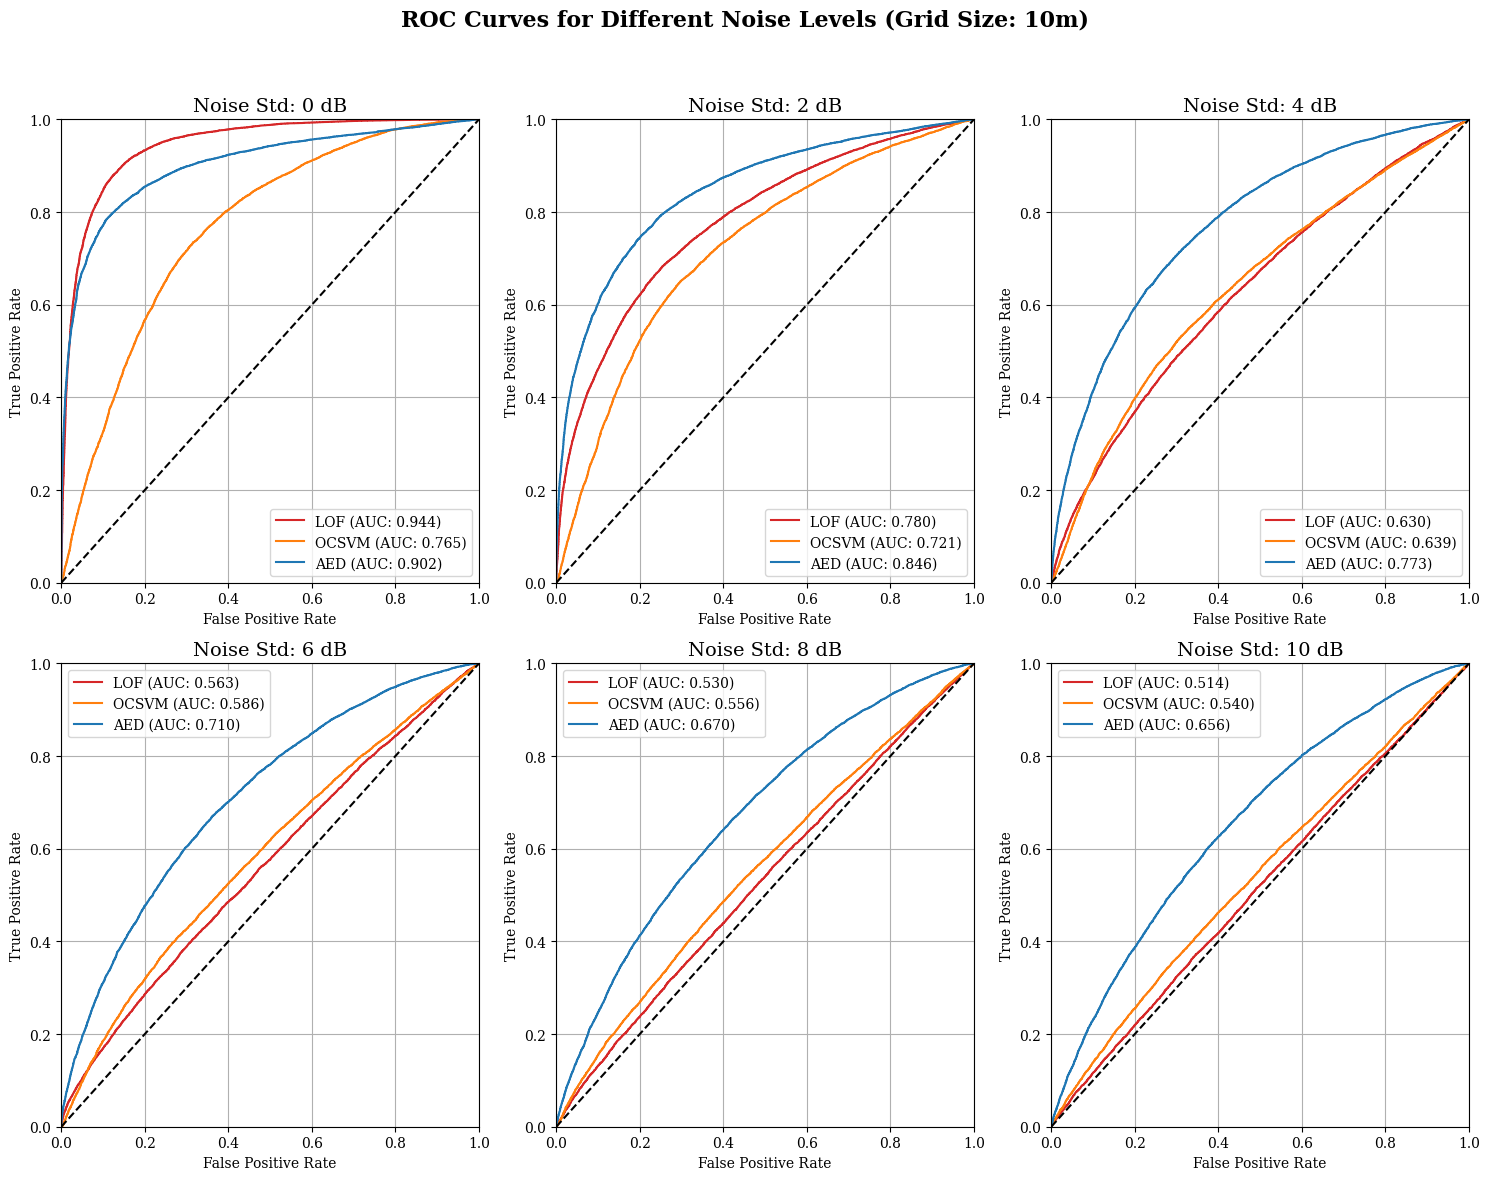

In [8]:
if param == 'noise_std':
    fig, ax = plt.subplots(2, 3, figsize=(15, 12))  # Adjust figure size for better spacing
    for ax_idx, noise_std in enumerate(np.arange(0, 11, 2)):
        row, col = divmod(ax_idx, 3)  # Compute subplot position
        plot_roc_for_one_config(10, noise_std, ax[row, col])  # Plot ROC for the current noise_std
        ax[row, col].set_title(f"Noise Std: {noise_std} dB", fontsize=14)  # Add descriptive titles

    # Adjust spacing and add a main title
    fig.suptitle("ROC Curves for Different Noise Levels (Grid Size: 10m)", fontsize=16, weight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
    plt.show()
elif param == 'grid_size':
    fig, ax = plt.subplots(2, 2, figsize=(12, 12))  # Adjust figure size for better spacing
    for ax_idx, grid_size in enumerate(np.arange(5, 25, 5)):
        row, col = divmod(ax_idx, 2)  # Compute subplot position
        plot_roc_for_one_config(grid_size, 2, ax[row, col])  # Plot ROC for the current grid size
        ax[row, col].set_title(f"Grid Size: {grid_size} m", fontsize=14)  # Add descriptive titles

    # Adjust spacing and add a main title
    fig.suptitle("ROC Curves for Different Grid Sizes (Noise Std: 2dB)", fontsize=16, weight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
    plt.show()

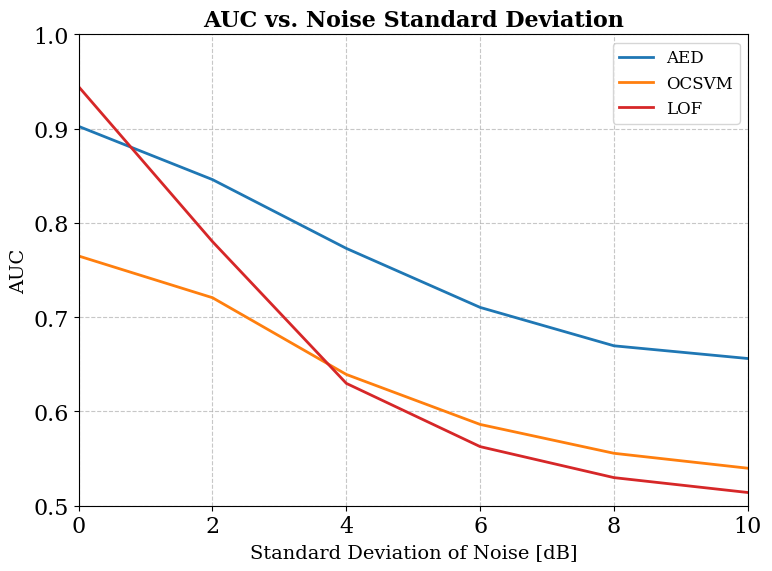

In [9]:
plt.rcParams['font.size'] = 16  # Set font size globally for clarity
plt.figure(figsize=(8, 6))  # Adjust figure size

# Plot AUC for each method
for method in auc_lists:
    if method in exclude_from_plot:
        continue
    plt.plot(
        auc_lists[method].keys(),
        auc_lists[method].values(),
        color=method_colors[method],
        label=method_labels[method],
        linewidth=2,  # Make lines thicker for better visibility
    )

# Add labels and title
plt.xlabel('Standard Deviation of Noise [dB]', fontsize=14)
plt.ylabel('AUC', fontsize=14)
plt.title('AUC vs. Noise Standard Deviation', fontsize=16, weight='bold')

# Configure axes
plt.xlim([0, 10])
plt.ylim([0.5, 1])
plt.grid(True, linestyle='--', alpha=0.7)  # Add a grid with light lines
plt.legend(fontsize=12)  # Adjust legend size
plt.tight_layout()

# Save the plot
figure_path = os.path.join(module_path, 'figures', 'fspl_anomaly_detection', f'auc-vs-{param}.pdf')
plt.savefig(figure_path, bbox_inches='tight')
plt.show()

Added some methods to plot the performance by grid size:

In [10]:
def plot_roc_curves_by_grid_size(noise_std, filenames_table, dataset_dir):
    """
    Plot ROC curves for all available grid sizes at a fixed noise standard deviation.

    Parameters:
        noise_std (float): Noise standard deviation to analyze.
        filenames_table (DataFrame): Table containing grid size, noise std, and filenames.
        dataset_dir (str): Directory containing dataset files.
    """
    grid_sizes = filenames_table['grid_size'].unique()  # Get unique grid sizes
    fig, axes = plt.subplots(2, len(grid_sizes) // 2, figsize=(16, 10))
    axes = axes.flatten()  # Flatten axes array for iteration

    for idx, grid_size in enumerate(grid_sizes):
        # Find the file corresponding to this grid size and noise std
        filename = filenames_table.loc[
            (filenames_table['grid_size'] == grid_size) & (filenames_table['noise_std'] == noise_std),
            'filename'
        ].values[0]
        dataset_nr = scanf('fspl_measurements%d', filename.split(os.sep)[-1])[0]

        with open(os.path.join(dataset_dir, f'fspl_results_{dataset_nr}_prob.pkl'), 'rb') as f_results:
            results = pickle.load(f_results)

        ax = axes[idx]
        for method in results:
            if method in exclude_from_plot:
                continue

            y_test = results[method]['y_test']
            y_hat = results[method]['y_hat']
            if method == 'one_class_svm':
                fpr, tpr, _ = roc_curve(y_test, -y_hat)
                auc = roc_auc_score(y_test, 1 - y_hat)
            else:
                fpr, tpr, _ = roc_curve(y_test, y_hat)
                auc = roc_auc_score(y_test, y_hat)

            ax.plot(fpr, tpr, color=method_colors[method], label=f'{method_labels[method]} (AUC: {auc:.3f})')

        ax.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random Guess')
        ax.set_title(f'Grid Size: {grid_size}m', fontsize=12)
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.grid(True)
        ax.legend(fontsize=10)

    fig.suptitle(f'ROC Curves by Grid Size (Noise Std: {noise_std} dB)', fontsize=16, weight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def plot_auc_vs_grid_size(noise_std, filenames_table, dataset_dir):
    """
    Plot AUC vs. grid size for all methods at a fixed noise standard deviation.

    Parameters:
        noise_std (float): Noise standard deviation to analyze.
        filenames_table (DataFrame): Table containing grid size, noise std, and filenames.
        dataset_dir (str): Directory containing dataset files.
    """
    grid_sizes = filenames_table['grid_size'].unique()  # Get unique grid sizes
    auc_lists = {method: {} for method in method_labels}  # Initialize AUC storage

    for grid_size in grid_sizes:
        # Find the file corresponding to this grid size and noise std
        filename = filenames_table.loc[
            (filenames_table['grid_size'] == grid_size) & (filenames_table['noise_std'] == noise_std),
            'filename'
        ].values[0]
        dataset_nr = scanf('fspl_measurements%d', filename.split(os.sep)[-1])[0]

        with open(os.path.join(dataset_dir, f'fspl_results_{dataset_nr}_prob.pkl'), 'rb') as f_results:
            results = pickle.load(f_results)

        for method in results:
            if method in exclude_from_plot:
                continue

            y_test = results[method]['y_test']
            y_hat = results[method]['y_hat']
            if method == 'one_class_svm':
                auc = roc_auc_score(y_test, 1 - y_hat)
            else:
                auc = roc_auc_score(y_test, y_hat)

            auc_lists[method][grid_size] = auc

    plt.figure(figsize=(8, 6))
    for method in auc_lists:
        if method in exclude_from_plot:
            continue
        plt.plot(
            auc_lists[method].keys(),
            auc_lists[method].values(),
            color=method_colors[method],
            label=method_labels[method],
            linewidth=2,
        )

    plt.title('AUC vs. Grid Size', fontsize=16, weight='bold')
    plt.xlabel('Grid Size [m]', fontsize=14)
    plt.ylabel('AUC', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()


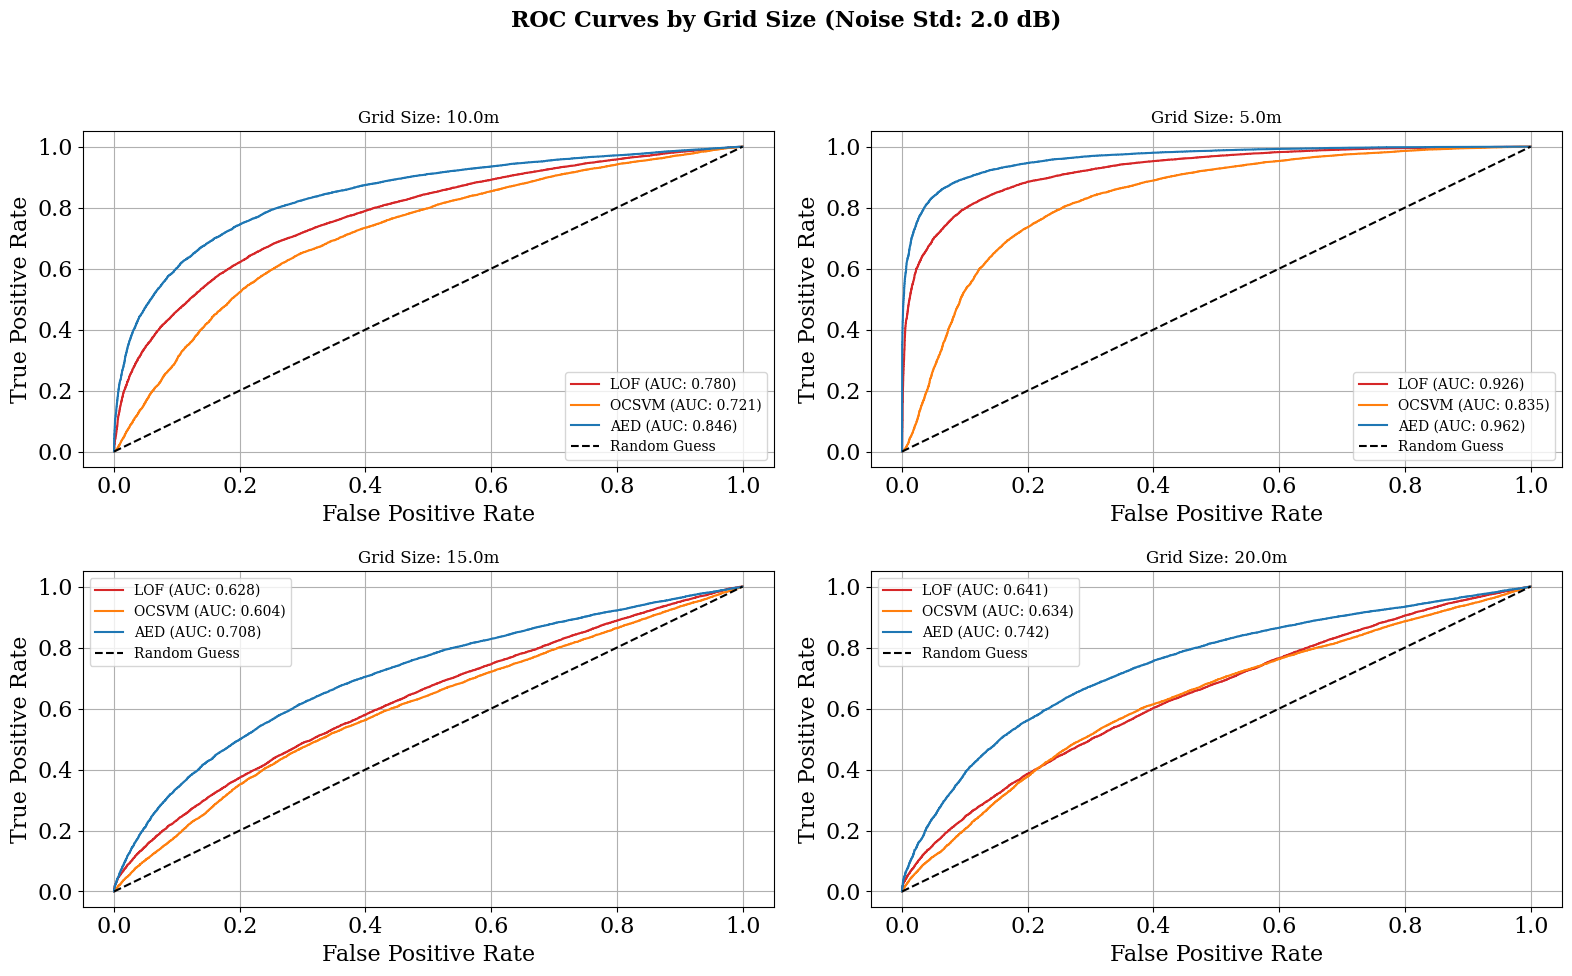

In [11]:
noise_std = 2.0  # Fixed noise standard deviation
plot_roc_curves_by_grid_size(noise_std, filenames_table, dataset_dir)

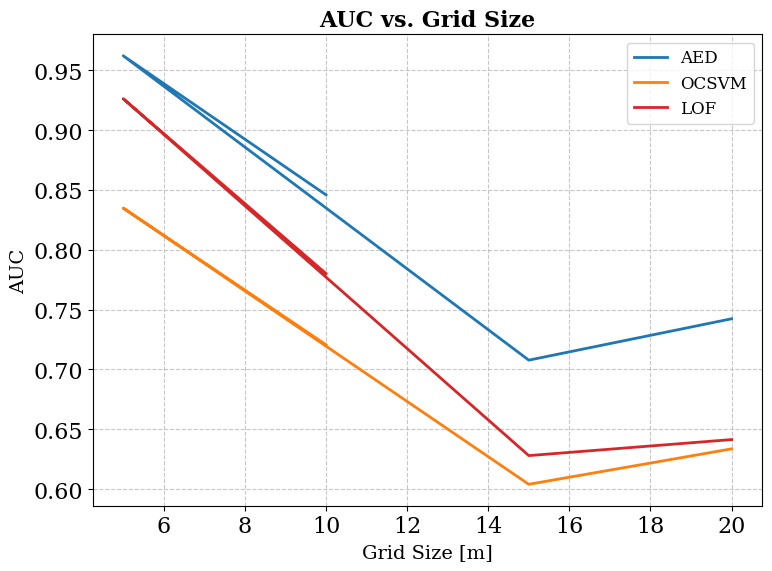

In [12]:
noise_std = 2.0  # Fixed noise standard deviation
plot_auc_vs_grid_size(noise_std, filenames_table, dataset_dir)

ROC Curves for two shadowing levels/grid sizes in one plot:

In [13]:
def load_results(grid_size, noise_std):
    """
    Load results from the dataset based on grid size and noise standard deviation.
    
    Parameters:
        grid_size (float): Grid size in meters.
        noise_std (float): Noise standard deviation in dB.
    
    Returns:
        dict: Results loaded from the dataset.
    """
    filename = description_file_utils.get_filename_by_params(
        filenames_table=filenames_table,
        noise_std=noise_std,
        grid_size=grid_size,
        tx_pos_inaccuracy_std=tx_pos_inaccuracy_std
    )
    dataset_nr = scanf('fspl_measurements%d', filename.split(os.sep)[-1])[0]
    with open(os.path.join(dataset_dir, f'fspl_results_{dataset_nr}_prob.pkl'), 'rb') as f_results:
        results = pickle.load(f_results)
    return results


def calculate_auc(y_test, y_hat, method):
    """
    Calculate the AUC score for a given method.
    
    Parameters:
        y_test (array-like): Ground truth labels.
        y_hat (array-like): Predicted scores.
        method (str): The name of the method.
    
    Returns:
        float: AUC score.
    """
    if method == 'one_class_svm':
        return roc_auc_score(y_test, 1 - y_hat)
    else:
        return roc_auc_score(y_test, y_hat)


def plot_roc_for_two_configs(grid_size, noise_std_by_config_idx, exclude_from_plot, linestyle_by_config_idx):
    """
    Plot ROC curves for two configurations.
    
    Parameters:
        grid_size (float): Grid size in meters.
        noise_std_by_config_idx (dict): Noise levels for configurations.
        exclude_from_plot (list): Methods to exclude from the plot.
        linestyle_by_config_idx (dict): Line styles for configurations.
    """
    legend_elements = []  # Store legend elements
    for config_idx, noise_std in noise_std_by_config_idx.items():
        # Load results
        results = load_results(grid_size, noise_std)

        # Plot ROC curves for each method
        for method in results:
            if method in exclude_from_plot:
                continue

            # Compute ROC curve
            y_test = results[method]['y_test']
            y_hat = results[method]['y_hat']
            fpr, tpr, _ = roc_curve(y_test, -y_hat if method == 'one_class_svm' else y_hat)

            # Plot the ROC curve
            plt.plot(fpr, tpr, color=method_colors[method],
                     linestyle=linestyle_by_config_idx[config_idx],
                     label=f'{method_labels[method]}' if config_idx == 0 else None)

            # Calculate AUC
            auc = calculate_auc(y_test, y_hat, method)

            # Add legend entry
            legend_label = f"{method_labels[method]} ($\\sigma$ = {noise_std} dB, AUC: {auc:.2f})"
            legend_elements.append(plt.Line2D([], [], color=method_colors[method], 
                                              linestyle=linestyle_by_config_idx[config_idx], 
                                              label=legend_label))

    # Add "No Skill" line
    plt.plot([0, 1], [0, 1], color='black', linestyle=':', linewidth=2, label='No skill')
    legend_elements.append(plt.Line2D([], [], color='black', linestyle=':', linewidth=2, label='No skill'))

    # Configure legend
    plt.legend(handles=legend_elements, fontsize=14, title="Method/Configuration", loc='lower right')

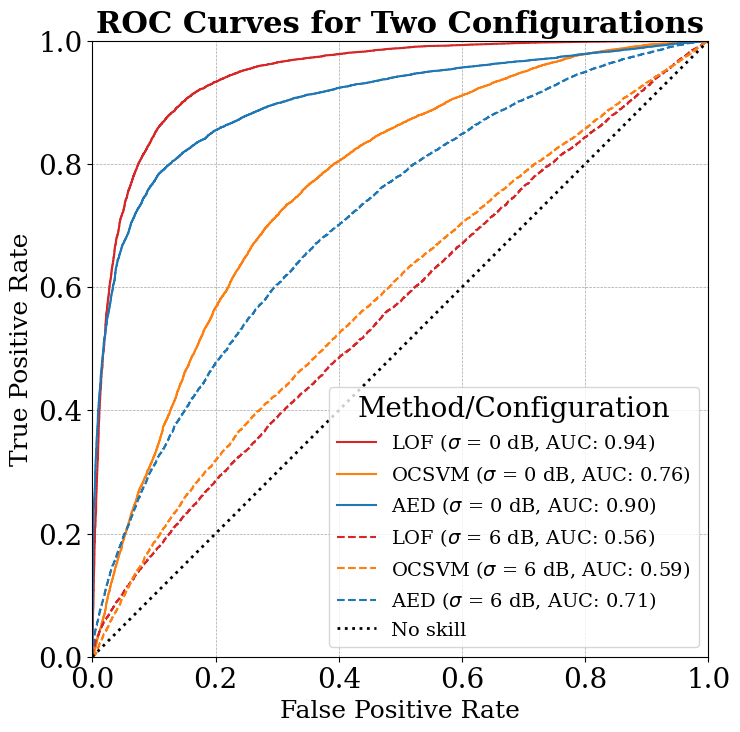

In [14]:
# Set parameters for the plot
param = 'noise_std'  # Choose 'noise_std' or 'grid_size'
exclude_from_plot = ['unsupervised_density', 'elliptic_envelope', 'dbscan']
linestyle_by_config_idx = {0: '-', 1: '--'}  # Line styles for two configurations
tx_pos_inaccuracy_std = 1.02  # Fixed parameter

# Plot configuration
plt.rcParams['font.size'] = 20  # Increase font size
plt.rcParams['figure.figsize'] = (8, 8)  # Larger figure size

# Noise levels for configurations
noise_std_by_config_idx = {0: 0, 1: 6}  # Two noise levels

# Call the plotting function
plot_roc_for_two_configs(10, noise_std_by_config_idx, exclude_from_plot, linestyle_by_config_idx)

# Configure labels, title, and grid
plt.title('ROC Curves for Two Configurations', fontsize=22, weight='bold')  # Larger title
plt.xlabel('False Positive Rate', fontsize=18)  # Larger x-label
plt.ylabel('True Positive Rate', fontsize=18)  # Larger y-label
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)  # Adjust grid style

# Set aspect ratio
plt.gca().set_aspect('equal', 'box')
plt.xlim([0, 1])
plt.ylim([0, 1])

# Save and show the plot
figure_path = os.path.join(module_path, 'figures', 'fspl_anomaly_detection', 'roc_curves-noise_std.pdf')
plt.savefig(figure_path, bbox_inches='tight')
plt.show()

Our additional implementation starts here:

1. Exploratory Data Analysis
    - 1.1 EDA using the provided class based methods
    - 1.2 EDA after convertin python objects to dataframes and using df based methods

Section 1.1: EDA using class based methods provided in the github

In [15]:
# methods

import pickle

from src.utils.radiomap_utils import plot_radio_map_difference

def load_radio_map_list(file_path):
    """
    Load a list of RadioMap objects from a .pkl file.

    Parameters:
        file_path (str): Path to the .pkl file.

    Returns:
        list: A list of RadioMap objects.
    """
    with open(file_path, "rb") as f:
        radio_map_list = pickle.load(f)
    if not isinstance(radio_map_list, list):
        raise ValueError("Expected a list of RadioMap objects.")
    return radio_map_list


def analyze_radio_map(radio_map):
    """
    Analyze and summarize a RadioMap object.

    Parameters:
        radio_map (RadioMap): The radio map object to analyze.
    """
    print("Radio Map Summary:")
    print(f"Resolution: {radio_map.resolution} meters")
    print(f"Radio Map Shape: {radio_map.radio_map.shape}")
    
    print("\nTransmitters:")
    for tx in radio_map.transmitters:
        print(f" - Type: {tx.tx_type}, Position: {tx.tx_pos}, Power: {tx.tx_power} dBm")
    
    print("\nJammers:")
    for jammer in radio_map.jammers:
        print(f" - Position: {jammer.tx_pos}, Power: {jammer.tx_power} dBm")


def visualize_radio_map(radio_map):
    """
    Visualize the radio map using its built-in method.

    Parameters:
        radio_map (RadioMap): The radio map object to visualize.
    """
    radio_map.show_radio_map(plot_transmitters=True, vmin=-100, vmax=0)


def compare_radio_maps(rm_orig, rm_dt, meas_x=[], meas_y=[]):
    """
    Compare two radio maps using the predefined utility function.

    Parameters:
        rm_orig (RadioMap): Original radio map.
        rm_dt (RadioMap): Digital twin radio map.
        meas_x (list): Measurement x-coordinates.
        meas_y (list): Measurement y-coordinates.
    """
    plot_radio_map_difference(rm_orig, rm_dt, plot_orig_tx=True, plot_dt_tx=True, meas_x=meas_x, meas_y=meas_y)


Loading: fspl_RMdataset0.pkl
Processing 5 sampled radio maps...

--- Radio Map 1 ---
Radio Map Summary:
Resolution: 1 meters
Radio Map Shape: (41, 41)

Transmitters:
 - Type: tx, Position: [2, 40], Power: 20 dBm
 - Type: tx, Position: [3, 39], Power: 20 dBm
 - Type: tx, Position: [6, 6], Power: 20 dBm
 - Type: tx, Position: [9, 31], Power: 20 dBm
 - Type: tx, Position: [12, 19], Power: 20 dBm
 - Type: tx, Position: [39, 31], Power: 20 dBm
 - Type: tx, Position: [18, 27], Power: 20 dBm
 - Type: tx, Position: [24, 13], Power: 20 dBm
 - Type: tx, Position: [9, 16], Power: 20 dBm
 - Type: tx, Position: [39, 20], Power: 20 dBm

Jammers:


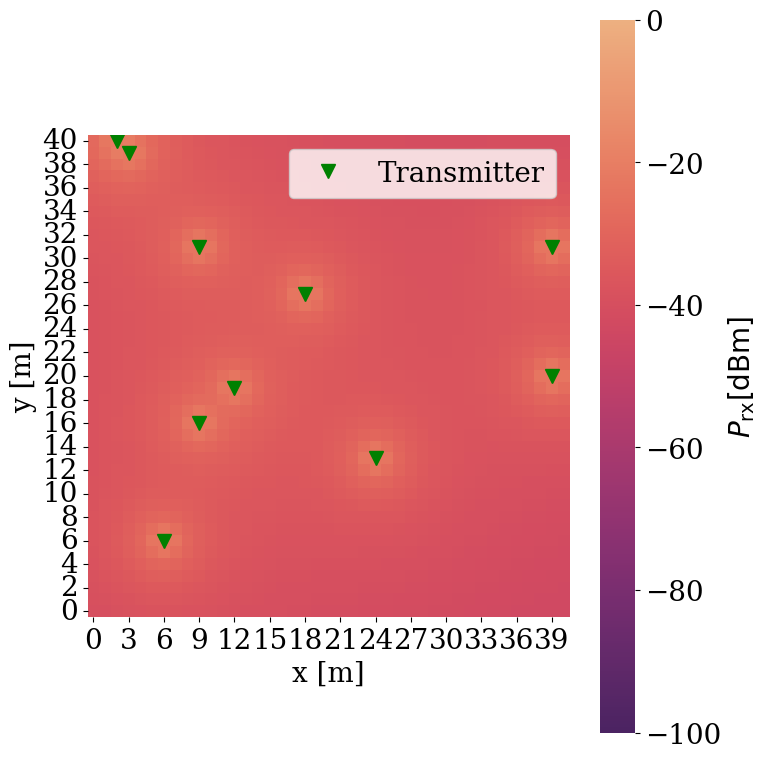


--- Radio Map 2 ---
Radio Map Summary:
Resolution: 1 meters
Radio Map Shape: (41, 41)

Transmitters:
 - Type: tx, Position: [8, 15], Power: 20 dBm
 - Type: tx, Position: [21, 6], Power: 20 dBm
 - Type: tx, Position: [24, 32], Power: 20 dBm
 - Type: tx, Position: [34, 25], Power: 20 dBm
 - Type: tx, Position: [21, 10], Power: 20 dBm
 - Type: tx, Position: [12, 15], Power: 20 dBm
 - Type: tx, Position: [4, 38], Power: 20 dBm
 - Type: tx, Position: [39, 30], Power: 20 dBm
 - Type: tx, Position: [12, 7], Power: 20 dBm
 - Type: tx, Position: [29, 35], Power: 20 dBm

Jammers:


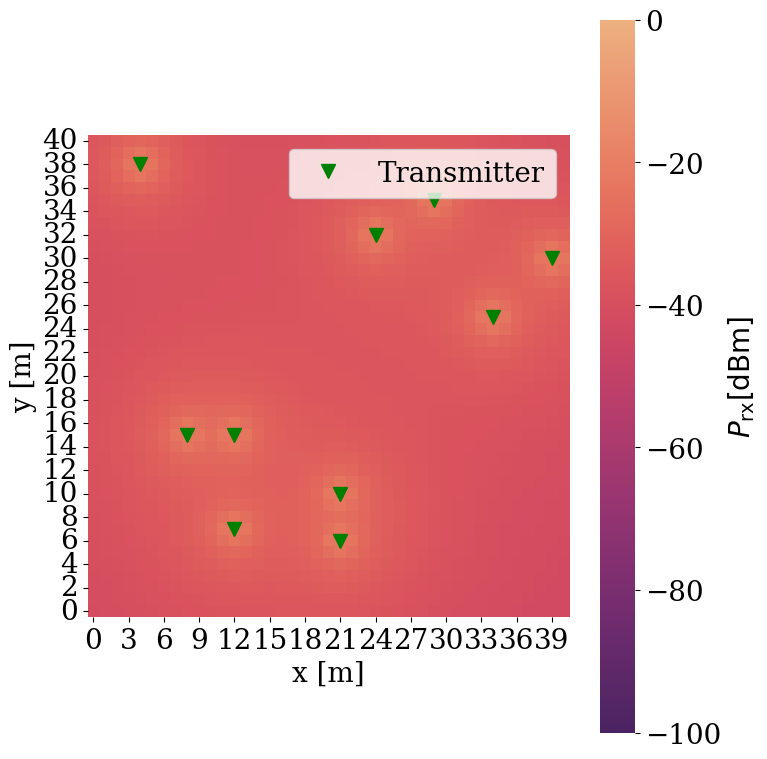


--- Radio Map 3 ---
Radio Map Summary:
Resolution: 1 meters
Radio Map Shape: (41, 41)

Transmitters:
 - Type: tx, Position: [14, 12], Power: 20 dBm
 - Type: tx, Position: [38, 20], Power: 20 dBm
 - Type: tx, Position: [26, 39], Power: 20 dBm
 - Type: tx, Position: [0, 18], Power: 20 dBm
 - Type: tx, Position: [2, 33], Power: 20 dBm
 - Type: tx, Position: [5, 30], Power: 20 dBm
 - Type: tx, Position: [40, 24], Power: 20 dBm
 - Type: tx, Position: [5, 18], Power: 20 dBm
 - Type: tx, Position: [36, 24], Power: 20 dBm
 - Type: tx, Position: [28, 32], Power: 20 dBm

Jammers:
 - Position: [13, 25], Power: 20.0 dBm


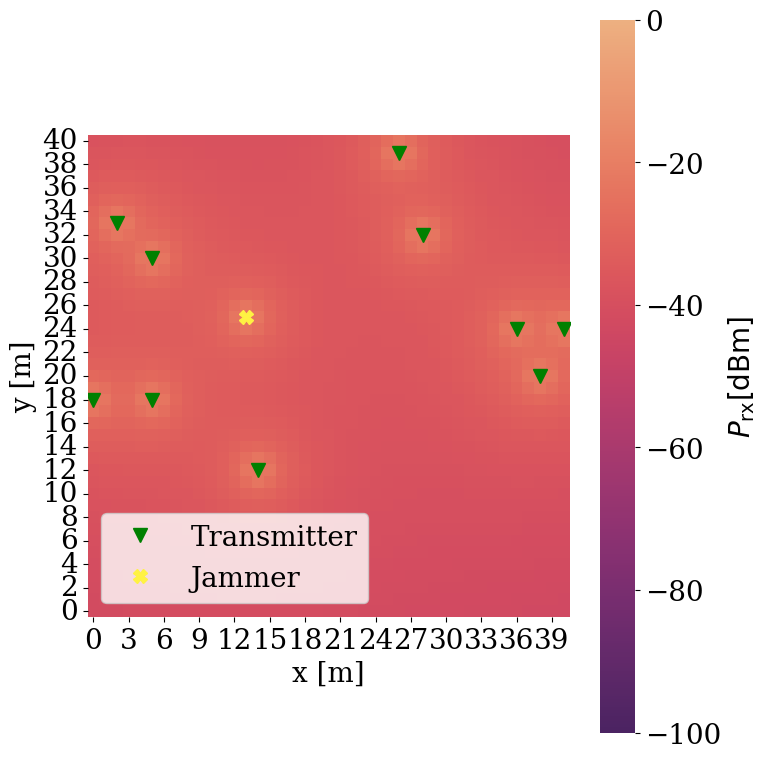


--- Radio Map 4 ---
Radio Map Summary:
Resolution: 1 meters
Radio Map Shape: (41, 41)

Transmitters:
 - Type: tx, Position: [24, 13], Power: 20 dBm
 - Type: tx, Position: [7, 27], Power: 20 dBm
 - Type: tx, Position: [9, 27], Power: 20 dBm
 - Type: tx, Position: [13, 27], Power: 20 dBm
 - Type: tx, Position: [34, 14], Power: 20 dBm
 - Type: tx, Position: [31, 14], Power: 20 dBm
 - Type: tx, Position: [38, 36], Power: 20 dBm
 - Type: tx, Position: [22, 11], Power: 20 dBm
 - Type: tx, Position: [29, 28], Power: 20 dBm
 - Type: tx, Position: [36, 5], Power: 20 dBm

Jammers:


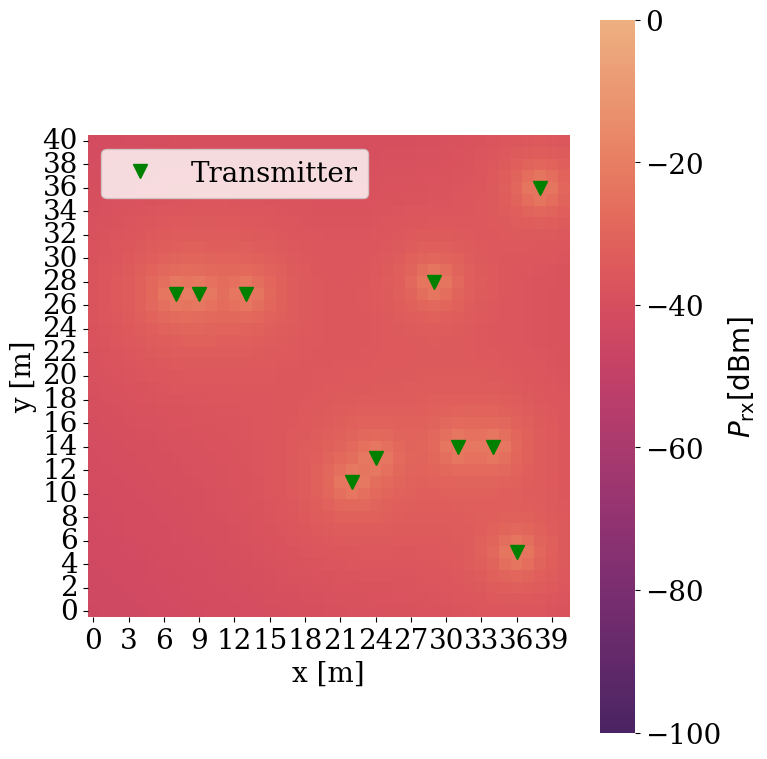


--- Radio Map 5 ---
Radio Map Summary:
Resolution: 1 meters
Radio Map Shape: (41, 41)

Transmitters:
 - Type: tx, Position: [30, 27], Power: 20 dBm
 - Type: tx, Position: [39, 3], Power: 20 dBm
 - Type: tx, Position: [9, 34], Power: 20 dBm
 - Type: tx, Position: [21, 26], Power: 20 dBm
 - Type: tx, Position: [25, 15], Power: 20 dBm
 - Type: tx, Position: [38, 6], Power: 20 dBm
 - Type: tx, Position: [3, 28], Power: 20 dBm
 - Type: tx, Position: [33, 4], Power: 20 dBm
 - Type: tx, Position: [22, 25], Power: 20 dBm
 - Type: tx, Position: [4, 9], Power: 20 dBm

Jammers:
 - Position: [8, 20], Power: 20.0 dBm


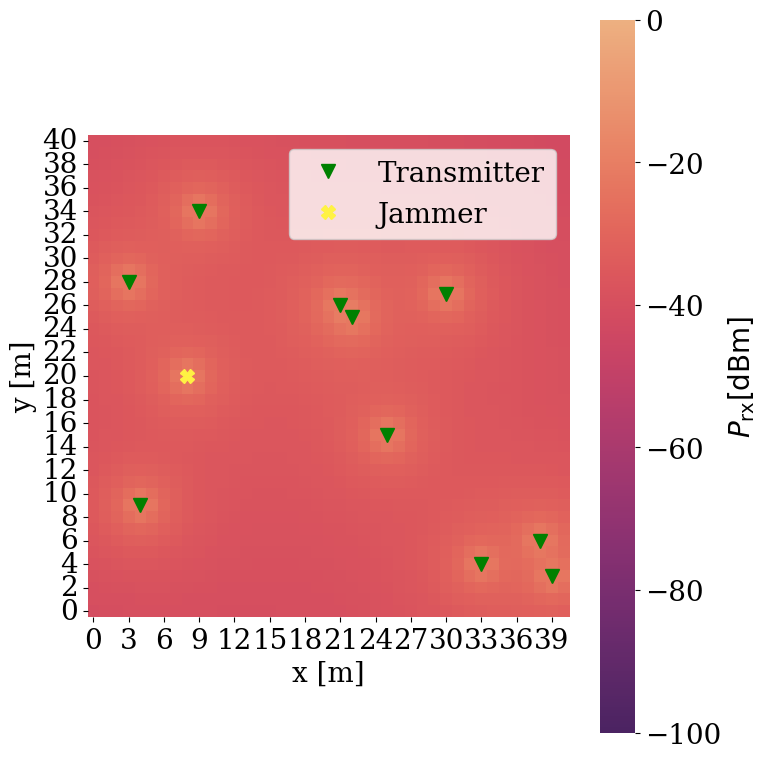


--- Comparing the First Two Radio Maps ---


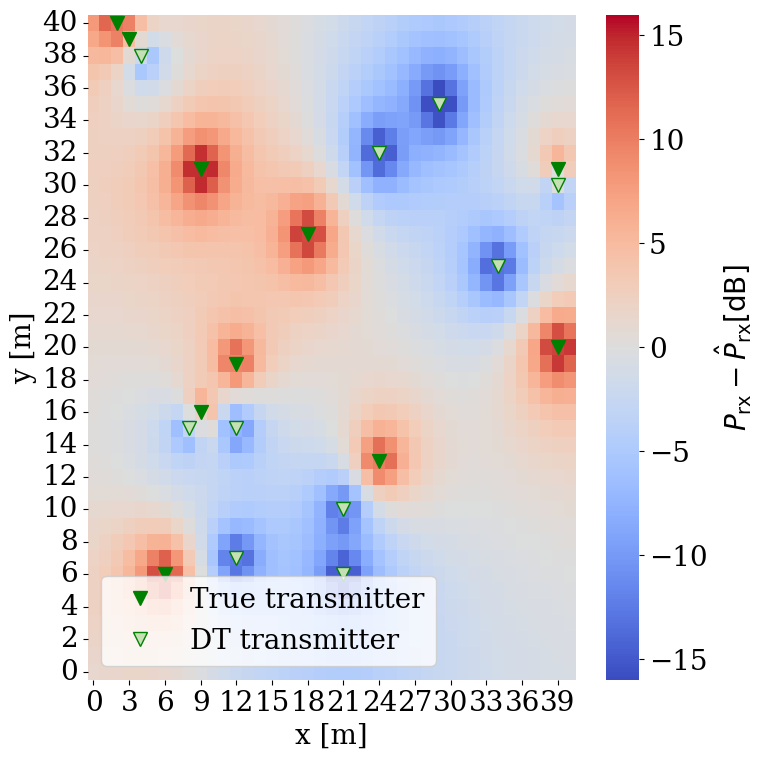

Loading: fspl_RMdataset1.pkl
Processing 5 sampled radio maps...

--- Radio Map 1 ---
Radio Map Summary:
Resolution: 1 meters
Radio Map Shape: (41, 41)

Transmitters:
 - Type: tx, Position: [23, 18], Power: 20 dBm
 - Type: tx, Position: [24, 31], Power: 20 dBm
 - Type: tx, Position: [1, 5], Power: 20 dBm
 - Type: tx, Position: [26, 33], Power: 20 dBm
 - Type: tx, Position: [30, 26], Power: 20 dBm
 - Type: tx, Position: [0, 7], Power: 20 dBm
 - Type: tx, Position: [30, 18], Power: 20 dBm
 - Type: tx, Position: [38, 32], Power: 20 dBm
 - Type: tx, Position: [33, 38], Power: 20 dBm
 - Type: tx, Position: [27, 15], Power: 20 dBm

Jammers:


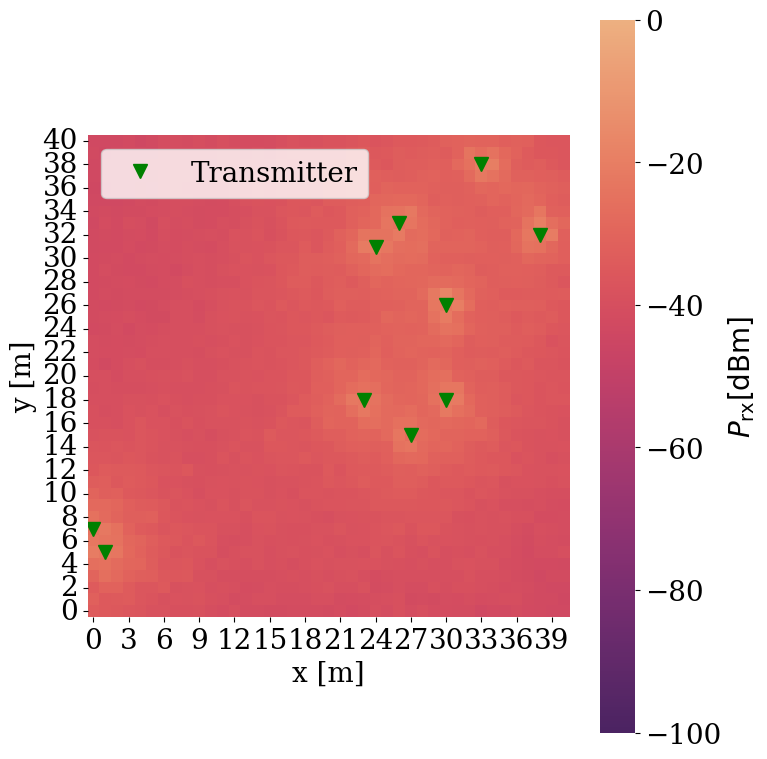


--- Radio Map 2 ---
Radio Map Summary:
Resolution: 1 meters
Radio Map Shape: (41, 41)

Transmitters:
 - Type: tx, Position: [12, 28], Power: 20 dBm
 - Type: tx, Position: [15, 6], Power: 20 dBm
 - Type: tx, Position: [16, 34], Power: 20 dBm
 - Type: tx, Position: [31, 17], Power: 20 dBm
 - Type: tx, Position: [12, 4], Power: 20 dBm
 - Type: tx, Position: [31, 7], Power: 20 dBm
 - Type: tx, Position: [8, 18], Power: 20 dBm
 - Type: tx, Position: [9, 40], Power: 20 dBm
 - Type: tx, Position: [14, 4], Power: 20 dBm
 - Type: tx, Position: [15, 34], Power: 20 dBm

Jammers:
 - Position: [22, 28], Power: 20.0 dBm


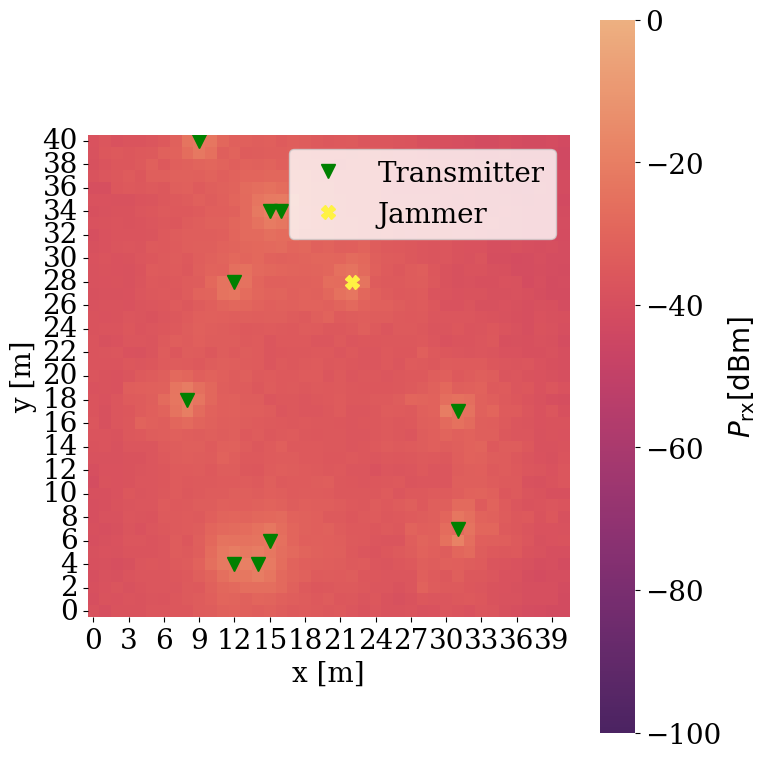


--- Radio Map 3 ---
Radio Map Summary:
Resolution: 1 meters
Radio Map Shape: (41, 41)

Transmitters:
 - Type: tx, Position: [6, 34], Power: 20 dBm
 - Type: tx, Position: [36, 31], Power: 20 dBm
 - Type: tx, Position: [27, 14], Power: 20 dBm
 - Type: tx, Position: [0, 10], Power: 20 dBm
 - Type: tx, Position: [16, 38], Power: 20 dBm
 - Type: tx, Position: [27, 15], Power: 20 dBm
 - Type: tx, Position: [22, 22], Power: 20 dBm
 - Type: tx, Position: [5, 16], Power: 20 dBm
 - Type: tx, Position: [1, 36], Power: 20 dBm
 - Type: tx, Position: [32, 34], Power: 20 dBm

Jammers:
 - Position: [18, 25], Power: 20.0 dBm


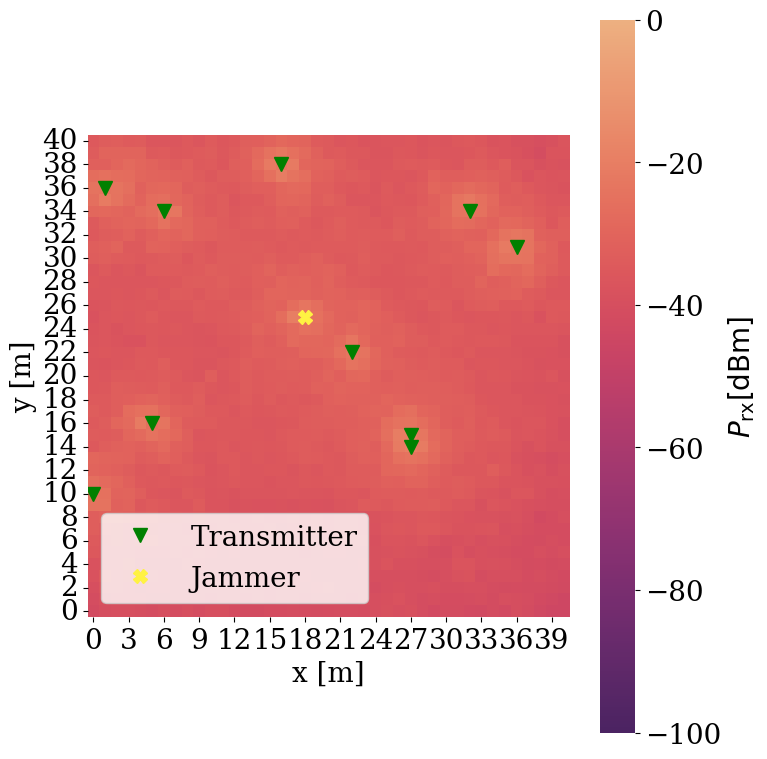


--- Radio Map 4 ---
Radio Map Summary:
Resolution: 1 meters
Radio Map Shape: (41, 41)

Transmitters:
 - Type: tx, Position: [3, 4], Power: 20 dBm
 - Type: tx, Position: [13, 19], Power: 20 dBm
 - Type: tx, Position: [8, 36], Power: 20 dBm
 - Type: tx, Position: [17, 31], Power: 20 dBm
 - Type: tx, Position: [38, 22], Power: 20 dBm
 - Type: tx, Position: [21, 9], Power: 20 dBm
 - Type: tx, Position: [29, 25], Power: 20 dBm
 - Type: tx, Position: [39, 19], Power: 20 dBm
 - Type: tx, Position: [22, 28], Power: 20 dBm
 - Type: tx, Position: [40, 20], Power: 20 dBm

Jammers:


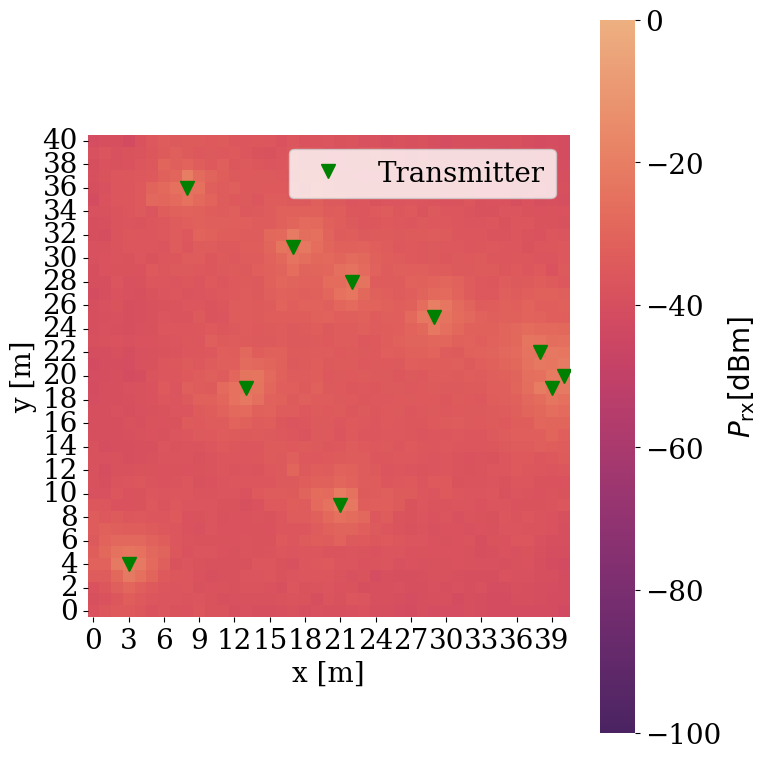


--- Radio Map 5 ---
Radio Map Summary:
Resolution: 1 meters
Radio Map Shape: (41, 41)

Transmitters:
 - Type: tx, Position: [28, 9], Power: 20 dBm
 - Type: tx, Position: [33, 38], Power: 20 dBm
 - Type: tx, Position: [0, 10], Power: 20 dBm
 - Type: tx, Position: [33, 38], Power: 20 dBm
 - Type: tx, Position: [36, 3], Power: 20 dBm
 - Type: tx, Position: [5, 14], Power: 20 dBm
 - Type: tx, Position: [20, 22], Power: 20 dBm
 - Type: tx, Position: [23, 7], Power: 20 dBm
 - Type: tx, Position: [27, 25], Power: 20 dBm
 - Type: tx, Position: [39, 1], Power: 20 dBm

Jammers:


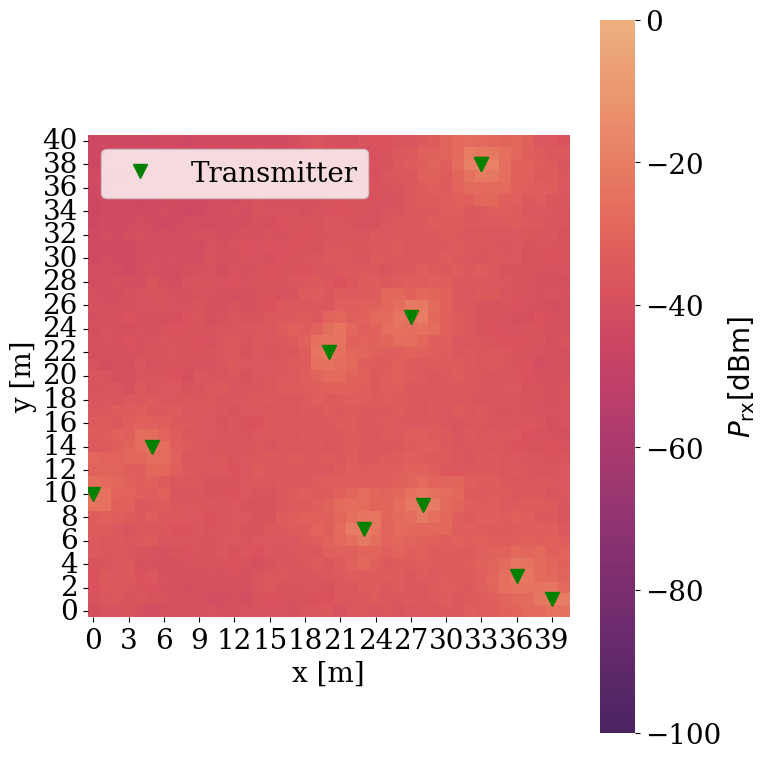


--- Comparing the First Two Radio Maps ---


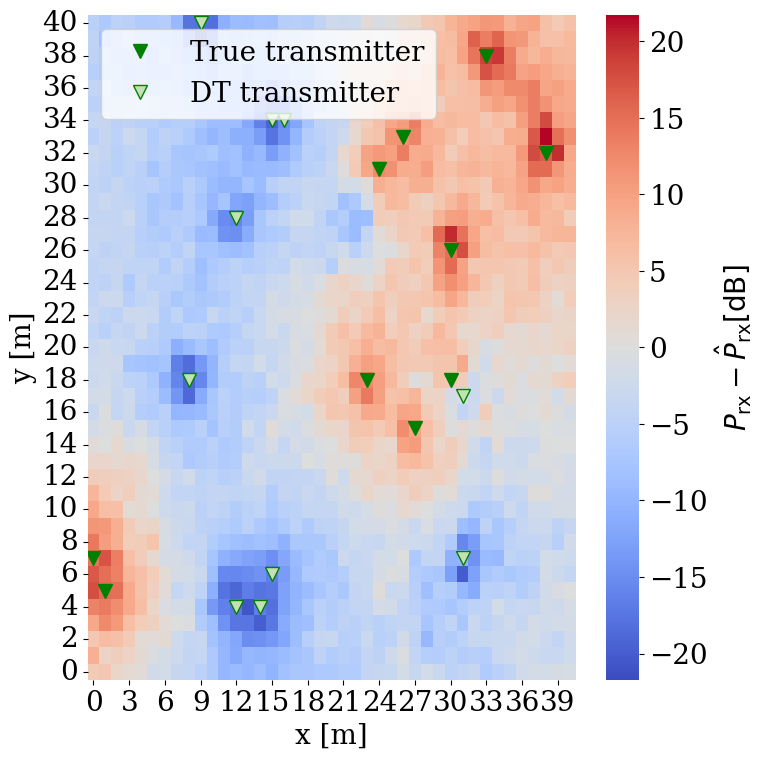

Loading: fspl_RMdataset2.pkl
Processing 5 sampled radio maps...

--- Radio Map 1 ---
Radio Map Summary:
Resolution: 1 meters
Radio Map Shape: (41, 41)

Transmitters:
 - Type: tx, Position: [39, 14], Power: 20 dBm
 - Type: tx, Position: [22, 29], Power: 20 dBm
 - Type: tx, Position: [19, 15], Power: 20 dBm
 - Type: tx, Position: [22, 37], Power: 20 dBm
 - Type: tx, Position: [5, 21], Power: 20 dBm
 - Type: tx, Position: [19, 16], Power: 20 dBm
 - Type: tx, Position: [0, 2], Power: 20 dBm
 - Type: tx, Position: [0, 30], Power: 20 dBm
 - Type: tx, Position: [40, 10], Power: 20 dBm
 - Type: tx, Position: [22, 38], Power: 20 dBm

Jammers:


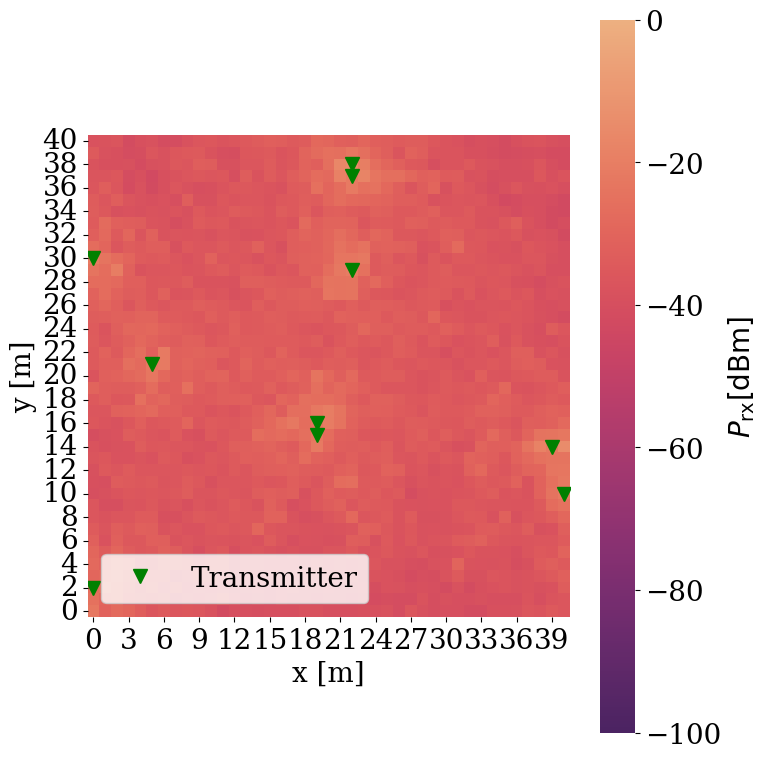


--- Radio Map 2 ---
Radio Map Summary:
Resolution: 1 meters
Radio Map Shape: (41, 41)

Transmitters:
 - Type: tx, Position: [23, 7], Power: 20 dBm
 - Type: tx, Position: [10, 8], Power: 20 dBm
 - Type: tx, Position: [18, 14], Power: 20 dBm
 - Type: tx, Position: [7, 20], Power: 20 dBm
 - Type: tx, Position: [13, 27], Power: 20 dBm
 - Type: tx, Position: [26, 30], Power: 20 dBm
 - Type: tx, Position: [11, 8], Power: 20 dBm
 - Type: tx, Position: [28, 21], Power: 20 dBm
 - Type: tx, Position: [16, 24], Power: 20 dBm
 - Type: tx, Position: [5, 29], Power: 20 dBm

Jammers:
 - Position: [39, 9], Power: 20.0 dBm


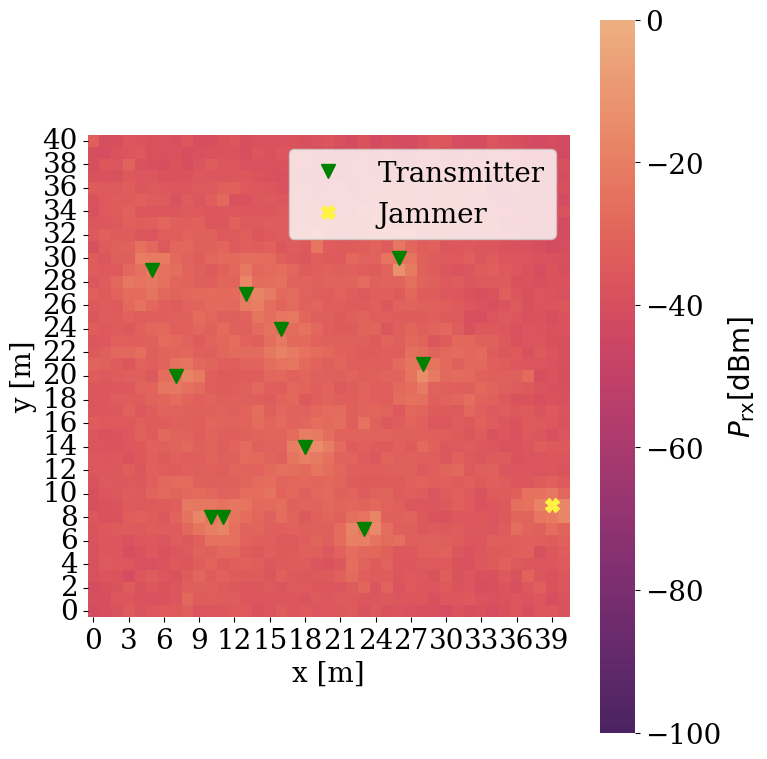


--- Radio Map 3 ---
Radio Map Summary:
Resolution: 1 meters
Radio Map Shape: (41, 41)

Transmitters:
 - Type: tx, Position: [38, 19], Power: 20 dBm
 - Type: tx, Position: [7, 19], Power: 20 dBm
 - Type: tx, Position: [38, 16], Power: 20 dBm
 - Type: tx, Position: [26, 34], Power: 20 dBm
 - Type: tx, Position: [0, 34], Power: 20 dBm
 - Type: tx, Position: [14, 22], Power: 20 dBm
 - Type: tx, Position: [26, 32], Power: 20 dBm
 - Type: tx, Position: [5, 6], Power: 20 dBm
 - Type: tx, Position: [11, 7], Power: 20 dBm
 - Type: tx, Position: [9, 18], Power: 20 dBm

Jammers:
 - Position: [2, 18], Power: 20.0 dBm


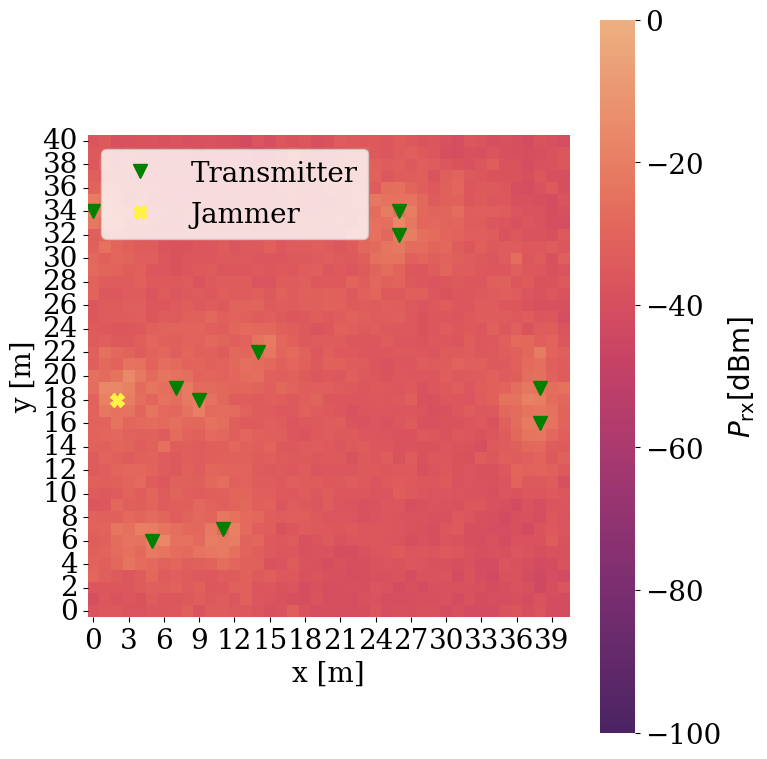


--- Radio Map 4 ---
Radio Map Summary:
Resolution: 1 meters
Radio Map Shape: (41, 41)

Transmitters:
 - Type: tx, Position: [4, 19], Power: 20 dBm
 - Type: tx, Position: [15, 7], Power: 20 dBm
 - Type: tx, Position: [3, 31], Power: 20 dBm
 - Type: tx, Position: [5, 5], Power: 20 dBm
 - Type: tx, Position: [23, 15], Power: 20 dBm
 - Type: tx, Position: [38, 17], Power: 20 dBm
 - Type: tx, Position: [9, 23], Power: 20 dBm
 - Type: tx, Position: [1, 13], Power: 20 dBm
 - Type: tx, Position: [17, 9], Power: 20 dBm
 - Type: tx, Position: [31, 34], Power: 20 dBm

Jammers:


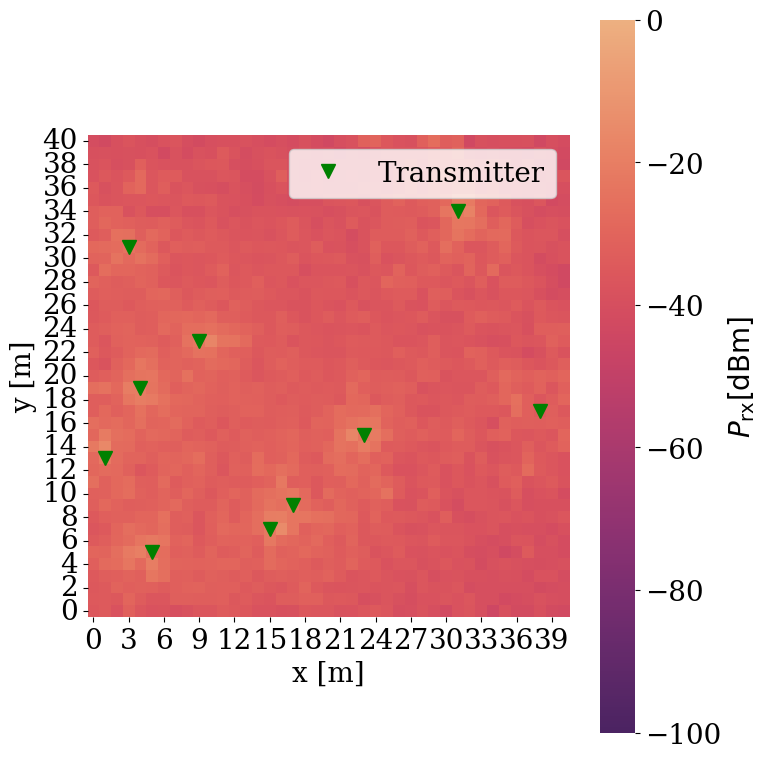


--- Radio Map 5 ---
Radio Map Summary:
Resolution: 1 meters
Radio Map Shape: (41, 41)

Transmitters:
 - Type: tx, Position: [14, 26], Power: 20 dBm
 - Type: tx, Position: [4, 13], Power: 20 dBm
 - Type: tx, Position: [38, 34], Power: 20 dBm
 - Type: tx, Position: [14, 13], Power: 20 dBm
 - Type: tx, Position: [37, 22], Power: 20 dBm
 - Type: tx, Position: [15, 14], Power: 20 dBm
 - Type: tx, Position: [10, 8], Power: 20 dBm
 - Type: tx, Position: [32, 10], Power: 20 dBm
 - Type: tx, Position: [30, 16], Power: 20 dBm
 - Type: tx, Position: [4, 22], Power: 20 dBm

Jammers:
 - Position: [11, 12], Power: 20.0 dBm


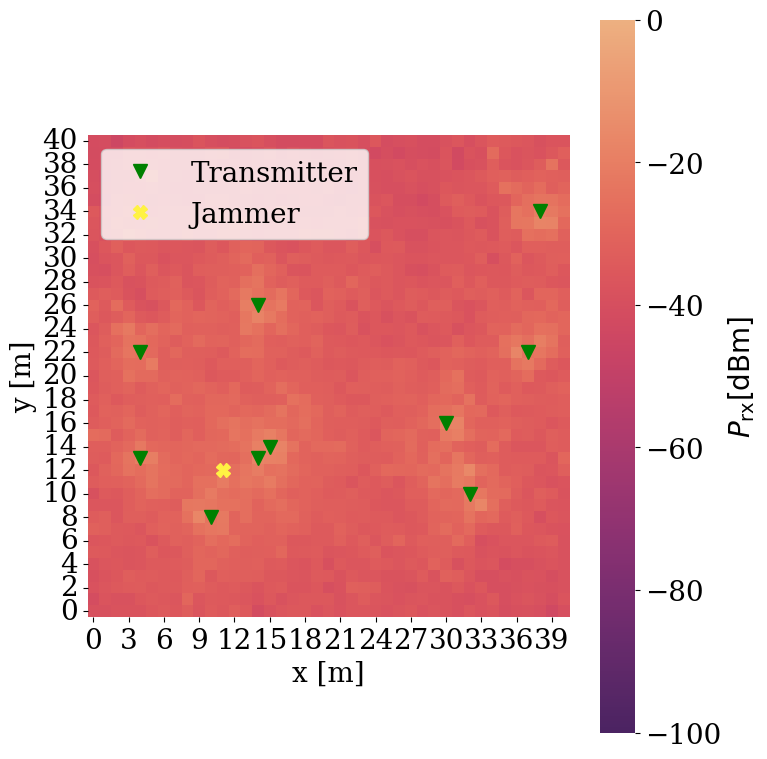


--- Comparing the First Two Radio Maps ---


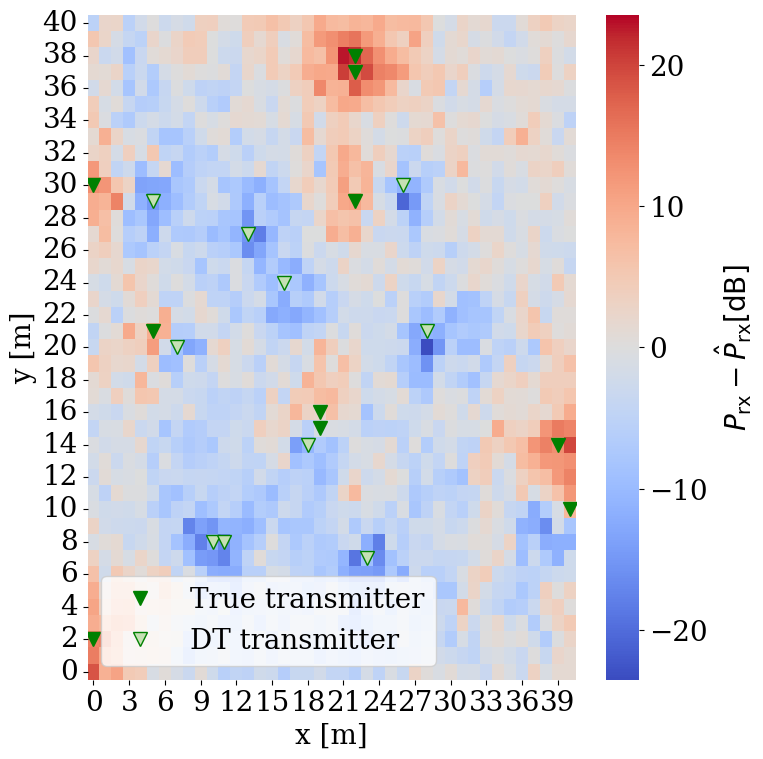

Loading: fspl_RMdataset3.pkl
Processing 5 sampled radio maps...

--- Radio Map 1 ---
Radio Map Summary:
Resolution: 1 meters
Radio Map Shape: (41, 41)

Transmitters:
 - Type: tx, Position: [22, 7], Power: 20 dBm
 - Type: tx, Position: [9, 32], Power: 20 dBm
 - Type: tx, Position: [13, 25], Power: 20 dBm
 - Type: tx, Position: [14, 23], Power: 20 dBm
 - Type: tx, Position: [37, 32], Power: 20 dBm
 - Type: tx, Position: [12, 40], Power: 20 dBm
 - Type: tx, Position: [24, 21], Power: 20 dBm
 - Type: tx, Position: [2, 1], Power: 20 dBm
 - Type: tx, Position: [3, 6], Power: 20 dBm
 - Type: tx, Position: [24, 30], Power: 20 dBm

Jammers:


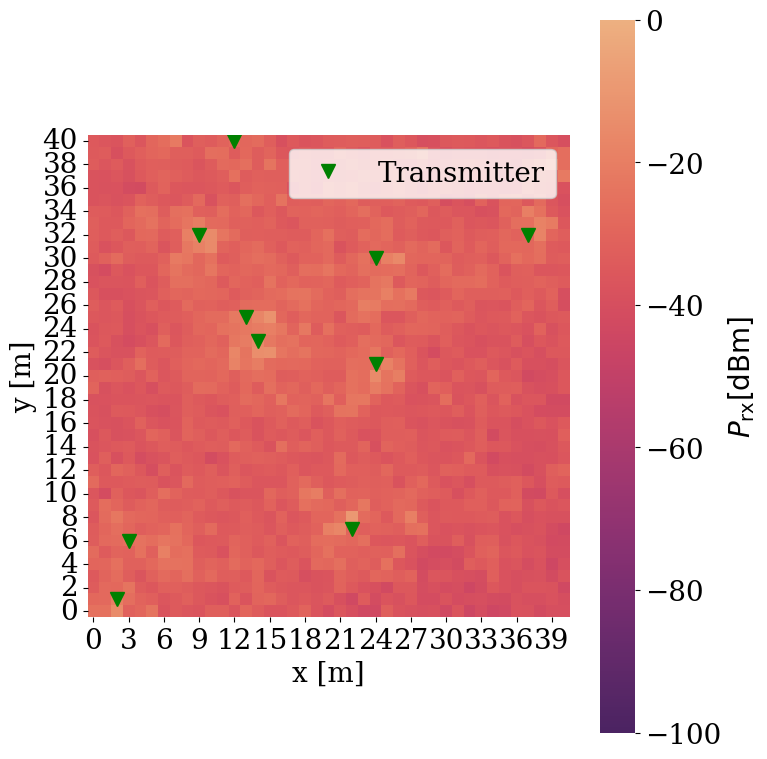


--- Radio Map 2 ---
Radio Map Summary:
Resolution: 1 meters
Radio Map Shape: (41, 41)

Transmitters:
 - Type: tx, Position: [11, 40], Power: 20 dBm
 - Type: tx, Position: [35, 28], Power: 20 dBm
 - Type: tx, Position: [27, 33], Power: 20 dBm
 - Type: tx, Position: [29, 33], Power: 20 dBm
 - Type: tx, Position: [5, 16], Power: 20 dBm
 - Type: tx, Position: [24, 2], Power: 20 dBm
 - Type: tx, Position: [40, 36], Power: 20 dBm
 - Type: tx, Position: [19, 33], Power: 20 dBm
 - Type: tx, Position: [3, 33], Power: 20 dBm
 - Type: tx, Position: [9, 33], Power: 20 dBm

Jammers:
 - Position: [37, 26], Power: 20.0 dBm


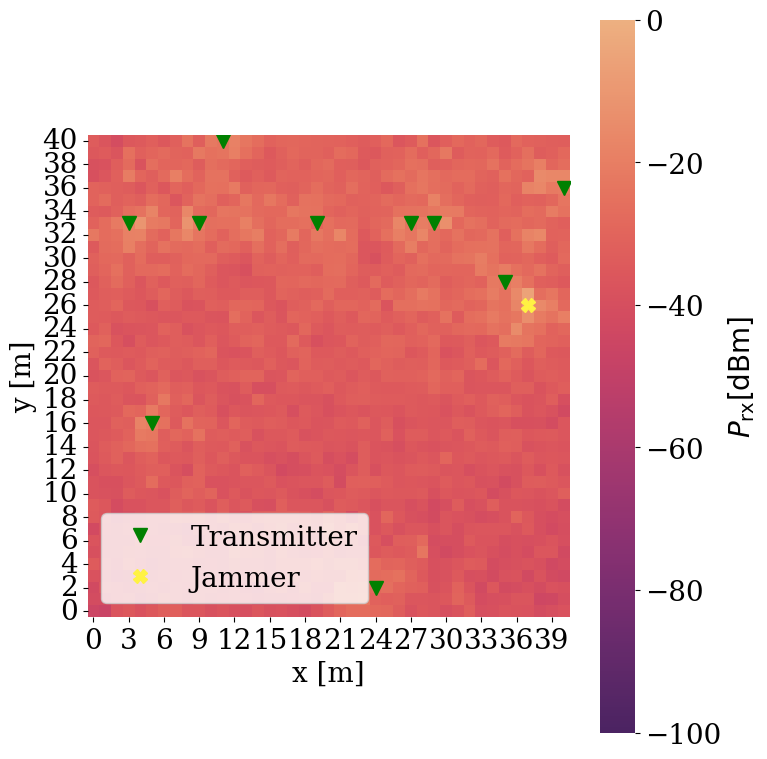


--- Radio Map 3 ---
Radio Map Summary:
Resolution: 1 meters
Radio Map Shape: (41, 41)

Transmitters:
 - Type: tx, Position: [40, 12], Power: 20 dBm
 - Type: tx, Position: [26, 2], Power: 20 dBm
 - Type: tx, Position: [37, 1], Power: 20 dBm
 - Type: tx, Position: [0, 31], Power: 20 dBm
 - Type: tx, Position: [32, 28], Power: 20 dBm
 - Type: tx, Position: [7, 35], Power: 20 dBm
 - Type: tx, Position: [2, 23], Power: 20 dBm
 - Type: tx, Position: [11, 19], Power: 20 dBm
 - Type: tx, Position: [26, 12], Power: 20 dBm
 - Type: tx, Position: [40, 15], Power: 20 dBm

Jammers:
 - Position: [36, 16], Power: 20.0 dBm


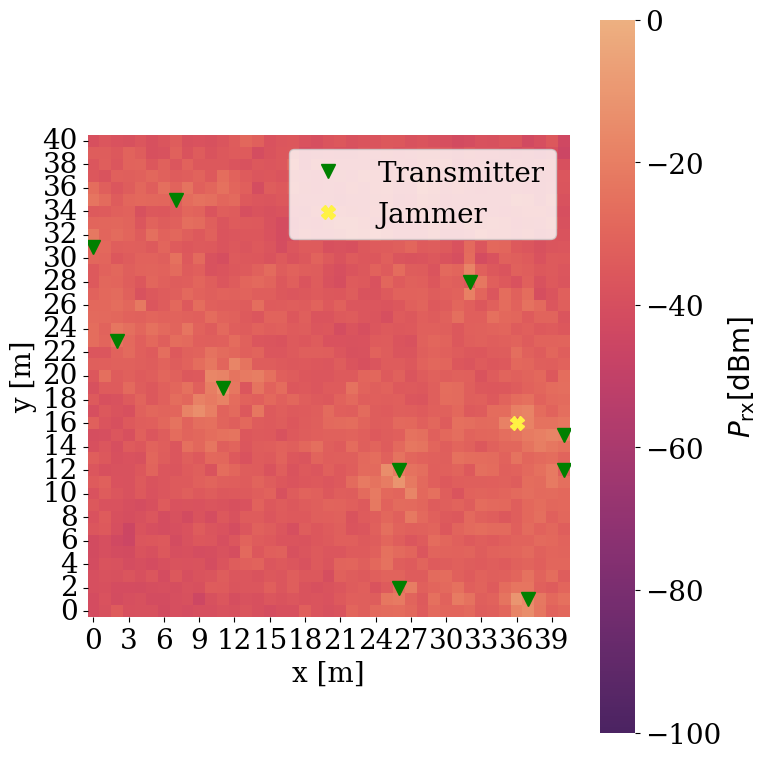


--- Radio Map 4 ---
Radio Map Summary:
Resolution: 1 meters
Radio Map Shape: (41, 41)

Transmitters:
 - Type: tx, Position: [24, 2], Power: 20 dBm
 - Type: tx, Position: [4, 37], Power: 20 dBm
 - Type: tx, Position: [1, 23], Power: 20 dBm
 - Type: tx, Position: [17, 37], Power: 20 dBm
 - Type: tx, Position: [15, 21], Power: 20 dBm
 - Type: tx, Position: [17, 39], Power: 20 dBm
 - Type: tx, Position: [9, 13], Power: 20 dBm
 - Type: tx, Position: [19, 19], Power: 20 dBm
 - Type: tx, Position: [16, 16], Power: 20 dBm
 - Type: tx, Position: [36, 5], Power: 20 dBm

Jammers:
 - Position: [13, 3], Power: 20.0 dBm


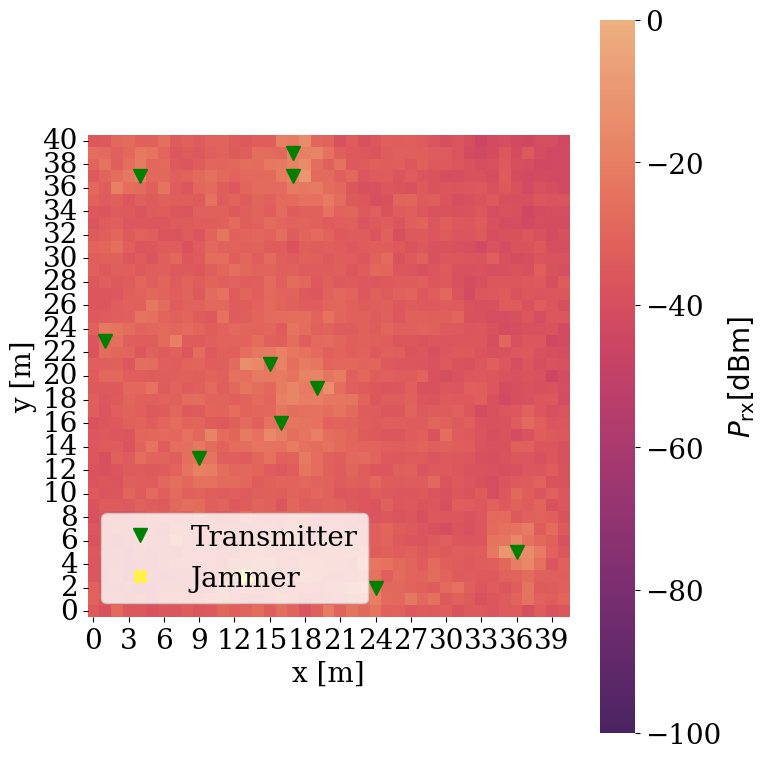


--- Radio Map 5 ---
Radio Map Summary:
Resolution: 1 meters
Radio Map Shape: (41, 41)

Transmitters:
 - Type: tx, Position: [37, 37], Power: 20 dBm
 - Type: tx, Position: [18, 9], Power: 20 dBm
 - Type: tx, Position: [35, 14], Power: 20 dBm
 - Type: tx, Position: [36, 21], Power: 20 dBm
 - Type: tx, Position: [36, 35], Power: 20 dBm
 - Type: tx, Position: [37, 28], Power: 20 dBm
 - Type: tx, Position: [26, 8], Power: 20 dBm
 - Type: tx, Position: [7, 21], Power: 20 dBm
 - Type: tx, Position: [29, 2], Power: 20 dBm
 - Type: tx, Position: [6, 23], Power: 20 dBm

Jammers:


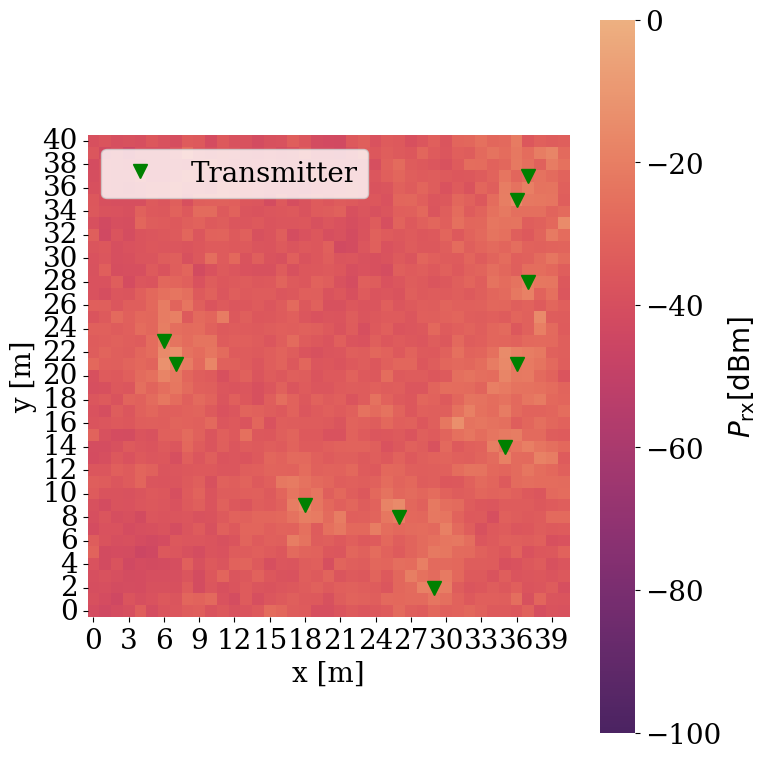


--- Comparing the First Two Radio Maps ---


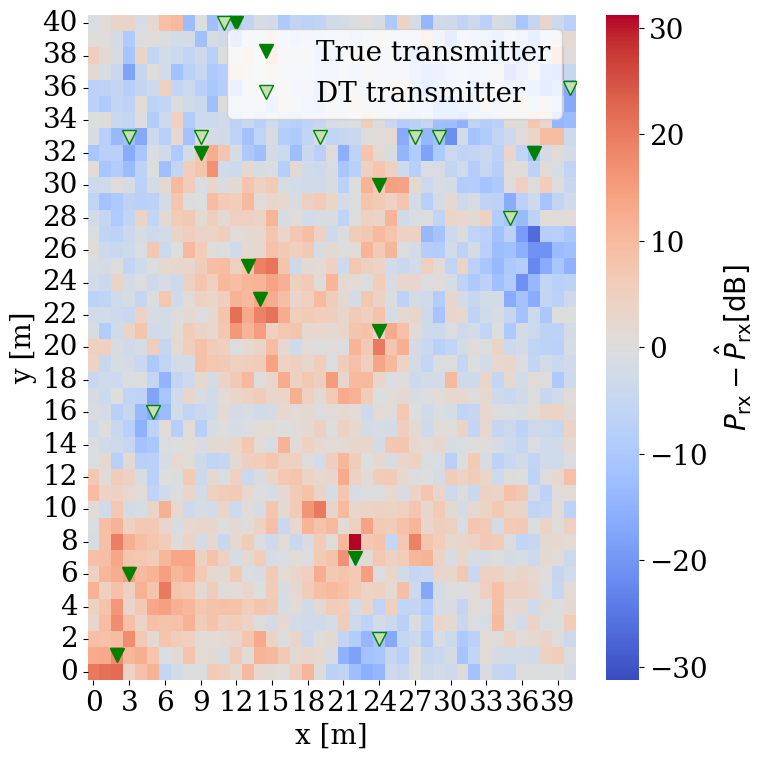

Loading: fspl_RMdataset4.pkl
Processing 5 sampled radio maps...

--- Radio Map 1 ---
Radio Map Summary:
Resolution: 1 meters
Radio Map Shape: (41, 41)

Transmitters:
 - Type: tx, Position: [17, 20], Power: 20 dBm
 - Type: tx, Position: [8, 15], Power: 20 dBm
 - Type: tx, Position: [15, 1], Power: 20 dBm
 - Type: tx, Position: [29, 32], Power: 20 dBm
 - Type: tx, Position: [32, 32], Power: 20 dBm
 - Type: tx, Position: [11, 31], Power: 20 dBm
 - Type: tx, Position: [22, 6], Power: 20 dBm
 - Type: tx, Position: [33, 30], Power: 20 dBm
 - Type: tx, Position: [37, 19], Power: 20 dBm
 - Type: tx, Position: [7, 22], Power: 20 dBm

Jammers:
 - Position: [6, 40], Power: 20.0 dBm


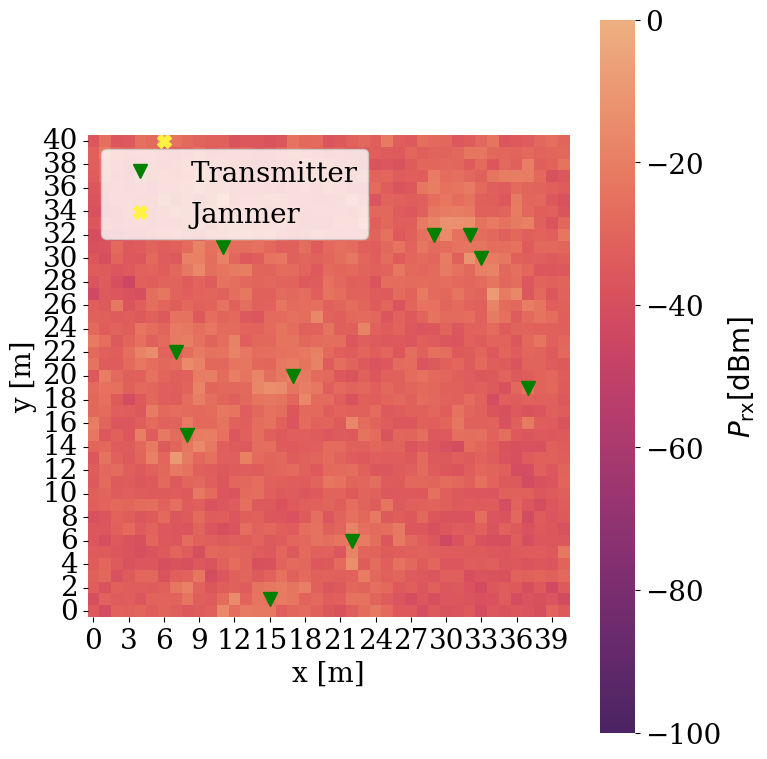


--- Radio Map 2 ---
Radio Map Summary:
Resolution: 1 meters
Radio Map Shape: (41, 41)

Transmitters:
 - Type: tx, Position: [8, 3], Power: 20 dBm
 - Type: tx, Position: [26, 11], Power: 20 dBm
 - Type: tx, Position: [26, 28], Power: 20 dBm
 - Type: tx, Position: [19, 9], Power: 20 dBm
 - Type: tx, Position: [35, 16], Power: 20 dBm
 - Type: tx, Position: [40, 35], Power: 20 dBm
 - Type: tx, Position: [13, 33], Power: 20 dBm
 - Type: tx, Position: [0, 14], Power: 20 dBm
 - Type: tx, Position: [39, 23], Power: 20 dBm
 - Type: tx, Position: [37, 9], Power: 20 dBm

Jammers:
 - Position: [18, 39], Power: 20.0 dBm


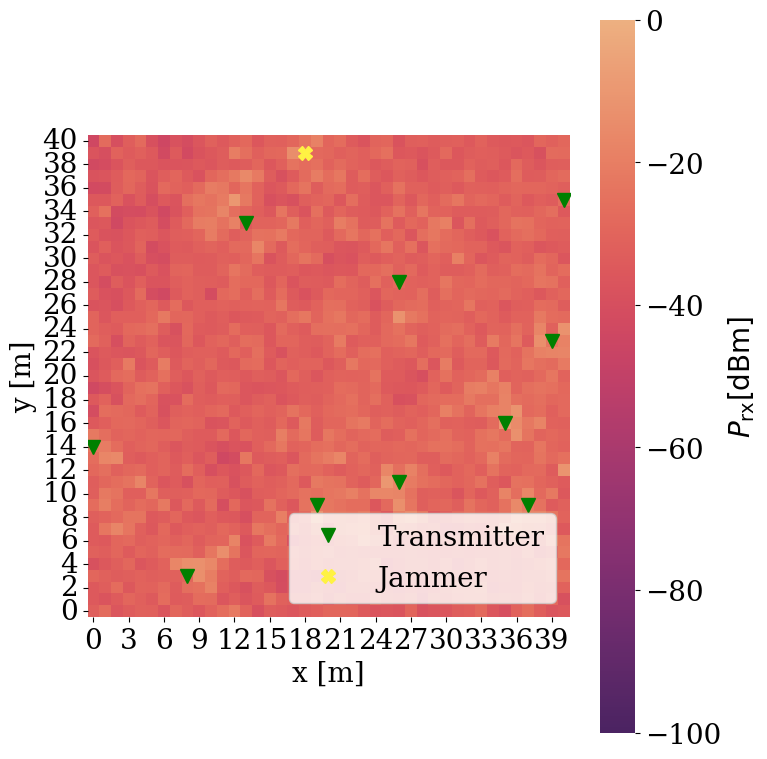


--- Radio Map 3 ---
Radio Map Summary:
Resolution: 1 meters
Radio Map Shape: (41, 41)

Transmitters:
 - Type: tx, Position: [6, 24], Power: 20 dBm
 - Type: tx, Position: [6, 5], Power: 20 dBm
 - Type: tx, Position: [5, 25], Power: 20 dBm
 - Type: tx, Position: [39, 33], Power: 20 dBm
 - Type: tx, Position: [27, 23], Power: 20 dBm
 - Type: tx, Position: [35, 22], Power: 20 dBm
 - Type: tx, Position: [30, 34], Power: 20 dBm
 - Type: tx, Position: [22, 22], Power: 20 dBm
 - Type: tx, Position: [32, 32], Power: 20 dBm
 - Type: tx, Position: [5, 17], Power: 20 dBm

Jammers:


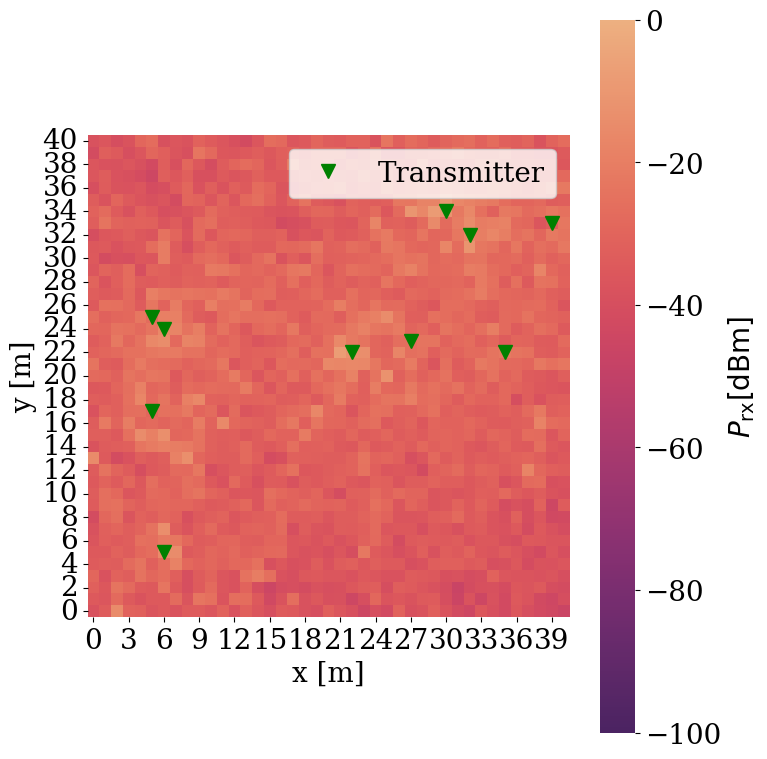


--- Radio Map 4 ---
Radio Map Summary:
Resolution: 1 meters
Radio Map Shape: (41, 41)

Transmitters:
 - Type: tx, Position: [32, 35], Power: 20 dBm
 - Type: tx, Position: [27, 18], Power: 20 dBm
 - Type: tx, Position: [39, 34], Power: 20 dBm
 - Type: tx, Position: [19, 32], Power: 20 dBm
 - Type: tx, Position: [16, 24], Power: 20 dBm
 - Type: tx, Position: [1, 34], Power: 20 dBm
 - Type: tx, Position: [38, 24], Power: 20 dBm
 - Type: tx, Position: [33, 8], Power: 20 dBm
 - Type: tx, Position: [1, 28], Power: 20 dBm
 - Type: tx, Position: [13, 33], Power: 20 dBm

Jammers:
 - Position: [18, 13], Power: 20.0 dBm


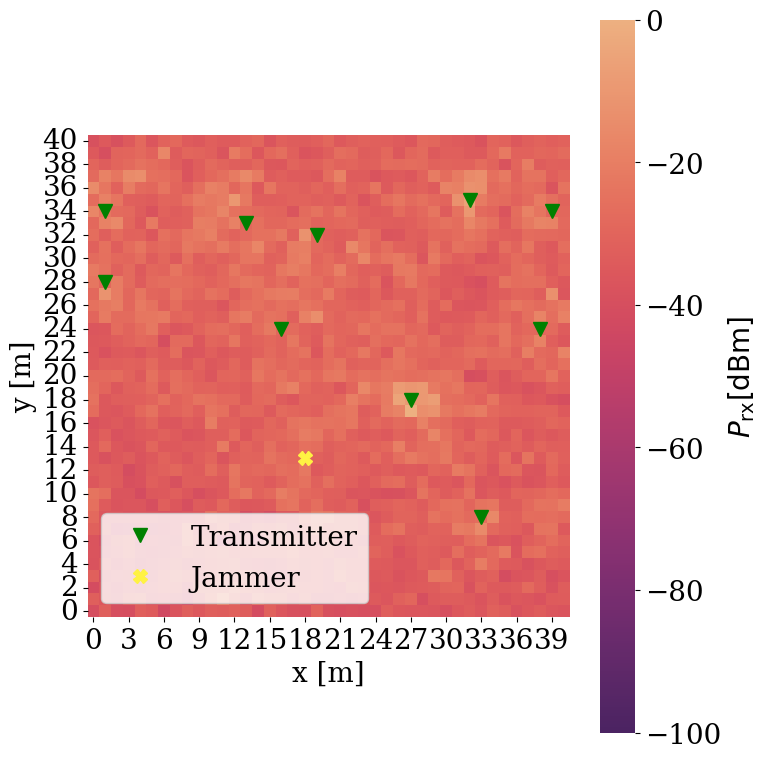


--- Radio Map 5 ---
Radio Map Summary:
Resolution: 1 meters
Radio Map Shape: (41, 41)

Transmitters:
 - Type: tx, Position: [33, 5], Power: 20 dBm
 - Type: tx, Position: [16, 4], Power: 20 dBm
 - Type: tx, Position: [31, 34], Power: 20 dBm
 - Type: tx, Position: [1, 12], Power: 20 dBm
 - Type: tx, Position: [19, 29], Power: 20 dBm
 - Type: tx, Position: [1, 31], Power: 20 dBm
 - Type: tx, Position: [20, 18], Power: 20 dBm
 - Type: tx, Position: [28, 14], Power: 20 dBm
 - Type: tx, Position: [21, 35], Power: 20 dBm
 - Type: tx, Position: [31, 32], Power: 20 dBm

Jammers:


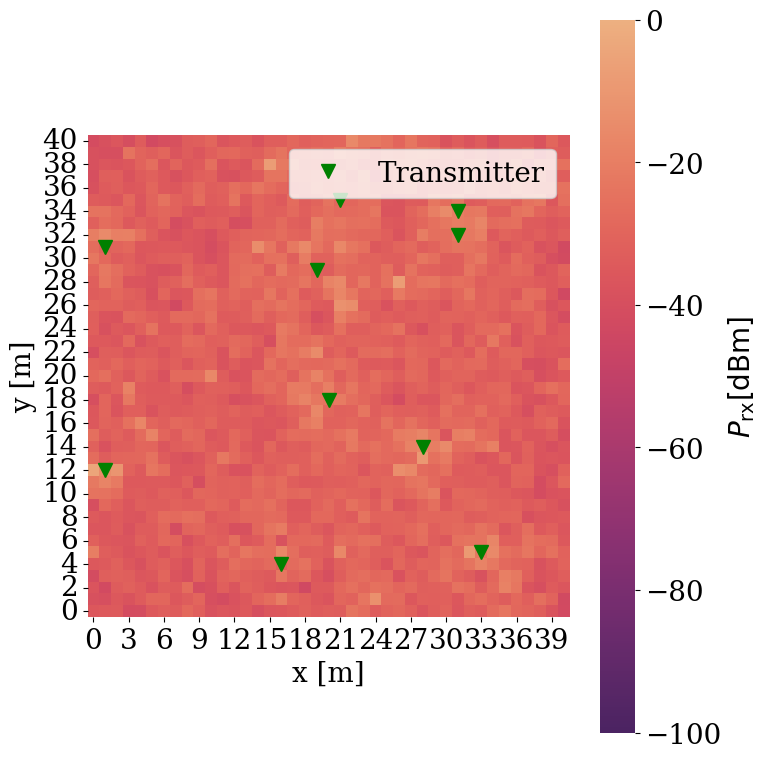


--- Comparing the First Two Radio Maps ---


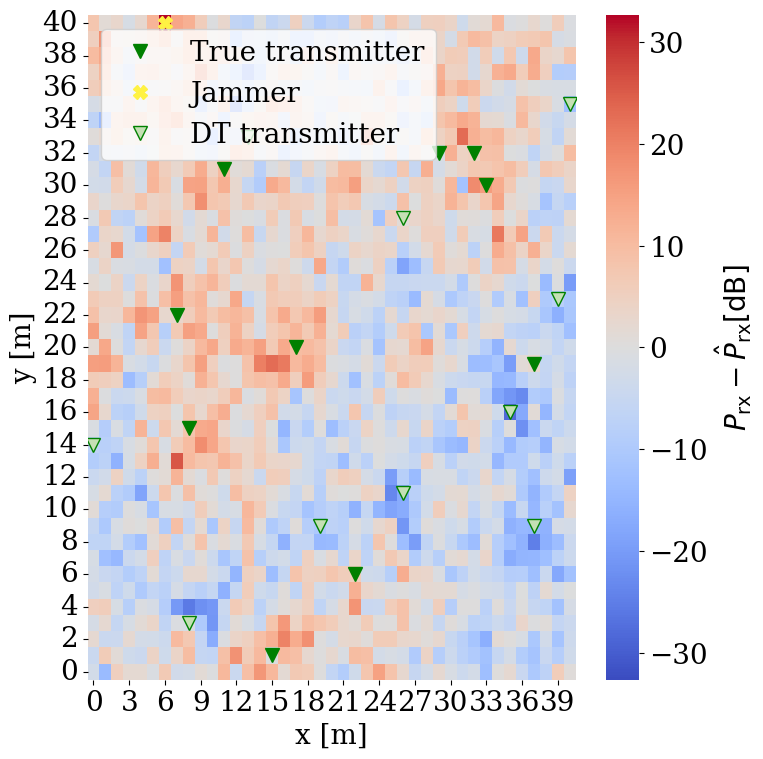

Loading: fspl_RMdataset5.pkl
Processing 5 sampled radio maps...

--- Radio Map 1 ---
Radio Map Summary:
Resolution: 1 meters
Radio Map Shape: (41, 41)

Transmitters:
 - Type: tx, Position: [29, 6], Power: 20 dBm
 - Type: tx, Position: [5, 32], Power: 20 dBm
 - Type: tx, Position: [23, 1], Power: 20 dBm
 - Type: tx, Position: [22, 14], Power: 20 dBm
 - Type: tx, Position: [38, 40], Power: 20 dBm
 - Type: tx, Position: [14, 10], Power: 20 dBm
 - Type: tx, Position: [19, 37], Power: 20 dBm
 - Type: tx, Position: [11, 25], Power: 20 dBm
 - Type: tx, Position: [11, 13], Power: 20 dBm
 - Type: tx, Position: [18, 23], Power: 20 dBm

Jammers:
 - Position: [14, 34], Power: 20.0 dBm


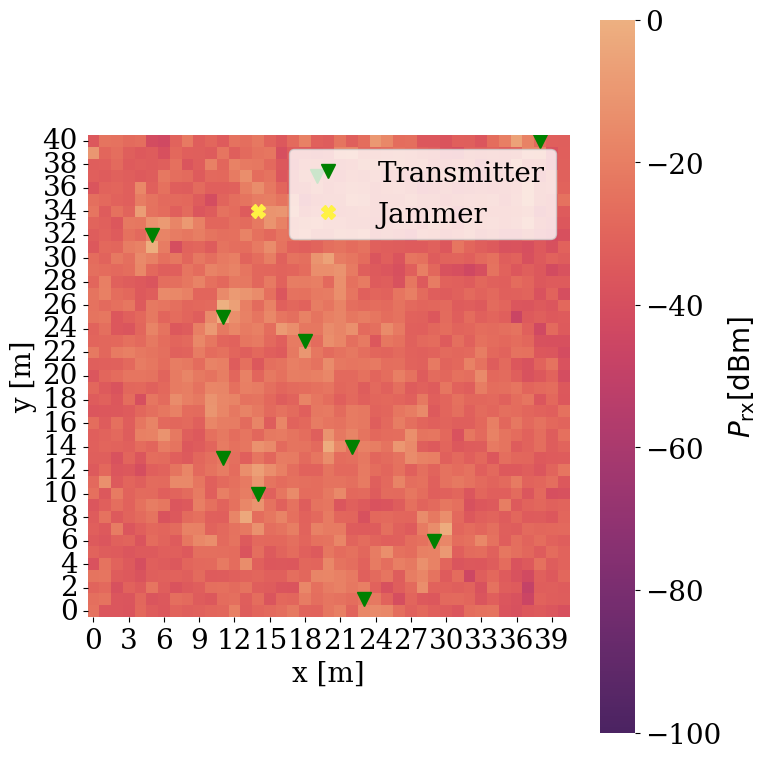


--- Radio Map 2 ---
Radio Map Summary:
Resolution: 1 meters
Radio Map Shape: (41, 41)

Transmitters:
 - Type: tx, Position: [2, 32], Power: 20 dBm
 - Type: tx, Position: [27, 21], Power: 20 dBm
 - Type: tx, Position: [31, 38], Power: 20 dBm
 - Type: tx, Position: [13, 33], Power: 20 dBm
 - Type: tx, Position: [37, 25], Power: 20 dBm
 - Type: tx, Position: [13, 22], Power: 20 dBm
 - Type: tx, Position: [19, 12], Power: 20 dBm
 - Type: tx, Position: [17, 36], Power: 20 dBm
 - Type: tx, Position: [26, 21], Power: 20 dBm
 - Type: tx, Position: [15, 18], Power: 20 dBm

Jammers:


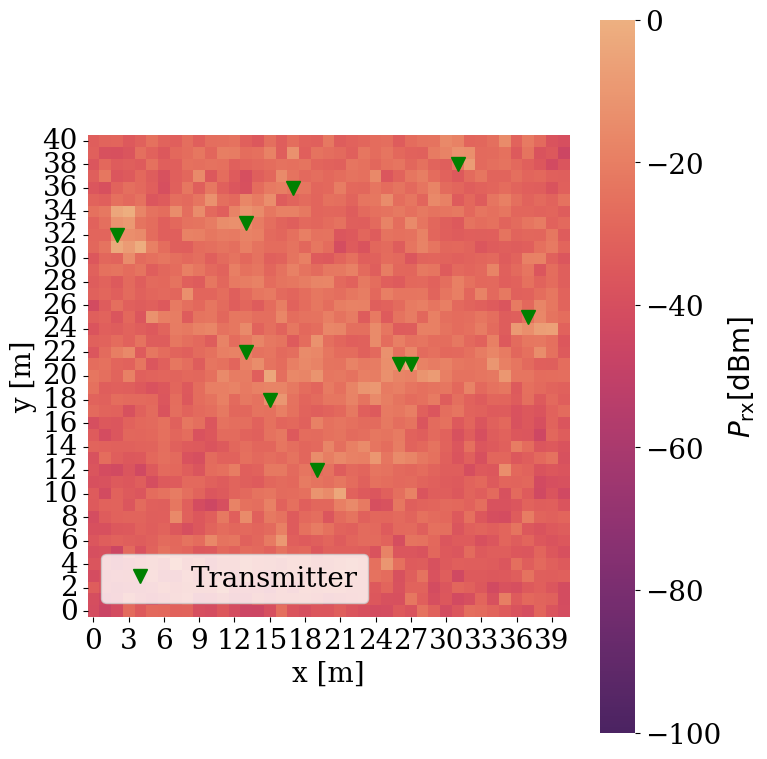


--- Radio Map 3 ---
Radio Map Summary:
Resolution: 1 meters
Radio Map Shape: (41, 41)

Transmitters:
 - Type: tx, Position: [0, 21], Power: 20 dBm
 - Type: tx, Position: [23, 32], Power: 20 dBm
 - Type: tx, Position: [23, 15], Power: 20 dBm
 - Type: tx, Position: [9, 11], Power: 20 dBm
 - Type: tx, Position: [16, 22], Power: 20 dBm
 - Type: tx, Position: [24, 39], Power: 20 dBm
 - Type: tx, Position: [40, 17], Power: 20 dBm
 - Type: tx, Position: [2, 38], Power: 20 dBm
 - Type: tx, Position: [7, 15], Power: 20 dBm
 - Type: tx, Position: [15, 9], Power: 20 dBm

Jammers:
 - Position: [27, 23], Power: 20.0 dBm


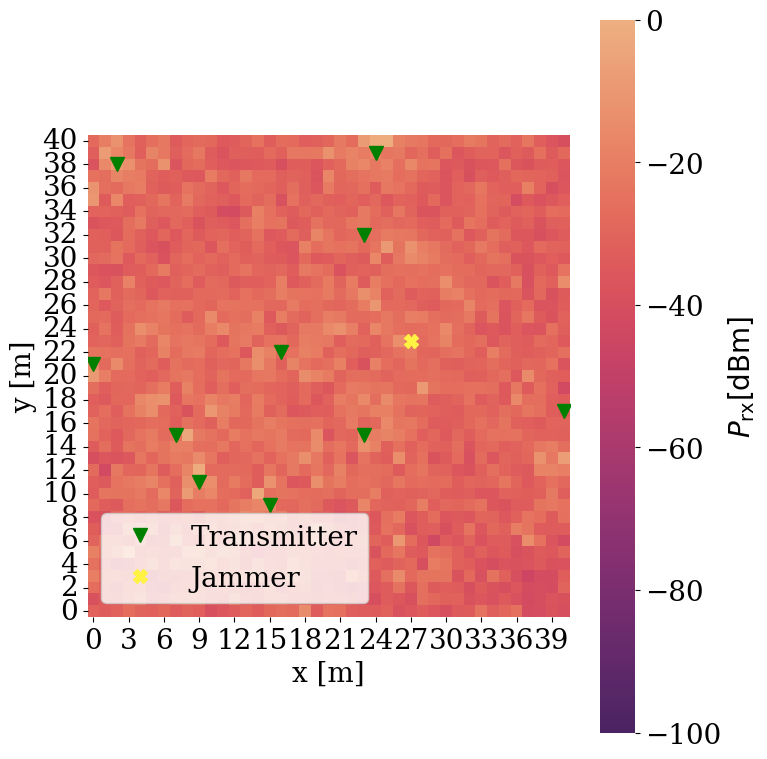


--- Radio Map 4 ---
Radio Map Summary:
Resolution: 1 meters
Radio Map Shape: (41, 41)

Transmitters:
 - Type: tx, Position: [35, 6], Power: 20 dBm
 - Type: tx, Position: [19, 24], Power: 20 dBm
 - Type: tx, Position: [40, 4], Power: 20 dBm
 - Type: tx, Position: [36, 3], Power: 20 dBm
 - Type: tx, Position: [5, 15], Power: 20 dBm
 - Type: tx, Position: [18, 22], Power: 20 dBm
 - Type: tx, Position: [10, 23], Power: 20 dBm
 - Type: tx, Position: [29, 4], Power: 20 dBm
 - Type: tx, Position: [13, 3], Power: 20 dBm
 - Type: tx, Position: [17, 24], Power: 20 dBm

Jammers:
 - Position: [23, 15], Power: 20.0 dBm


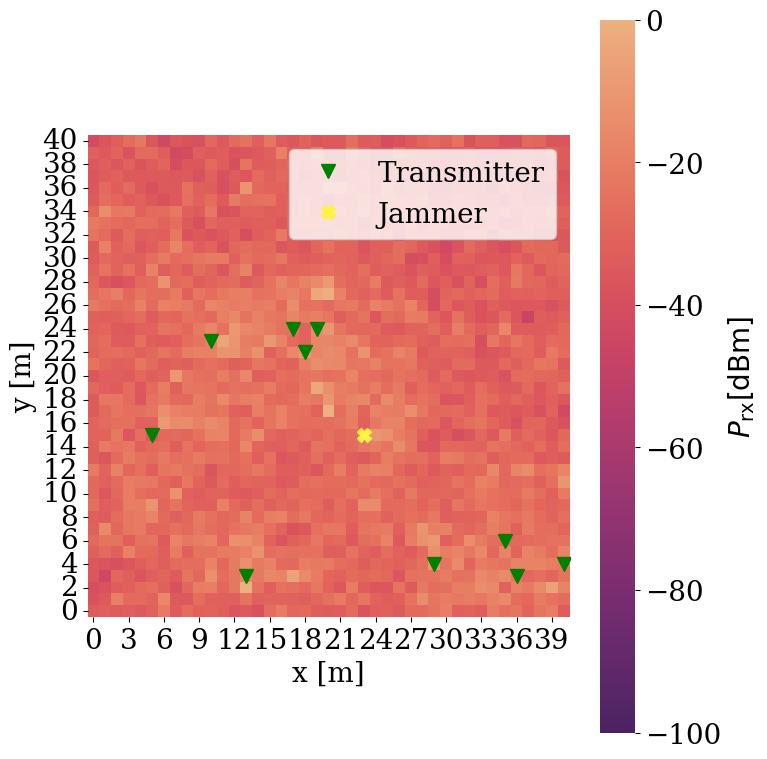


--- Radio Map 5 ---
Radio Map Summary:
Resolution: 1 meters
Radio Map Shape: (41, 41)

Transmitters:
 - Type: tx, Position: [13, 2], Power: 20 dBm
 - Type: tx, Position: [7, 15], Power: 20 dBm
 - Type: tx, Position: [24, 35], Power: 20 dBm
 - Type: tx, Position: [4, 10], Power: 20 dBm
 - Type: tx, Position: [10, 23], Power: 20 dBm
 - Type: tx, Position: [8, 19], Power: 20 dBm
 - Type: tx, Position: [25, 11], Power: 20 dBm
 - Type: tx, Position: [2, 38], Power: 20 dBm
 - Type: tx, Position: [12, 40], Power: 20 dBm
 - Type: tx, Position: [19, 21], Power: 20 dBm

Jammers:
 - Position: [40, 37], Power: 20.0 dBm


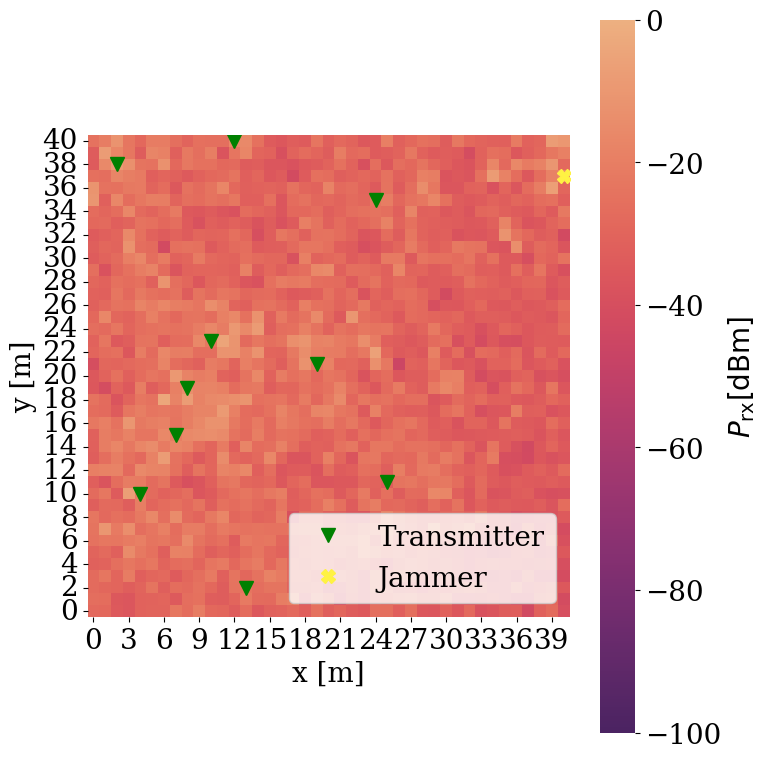


--- Comparing the First Two Radio Maps ---


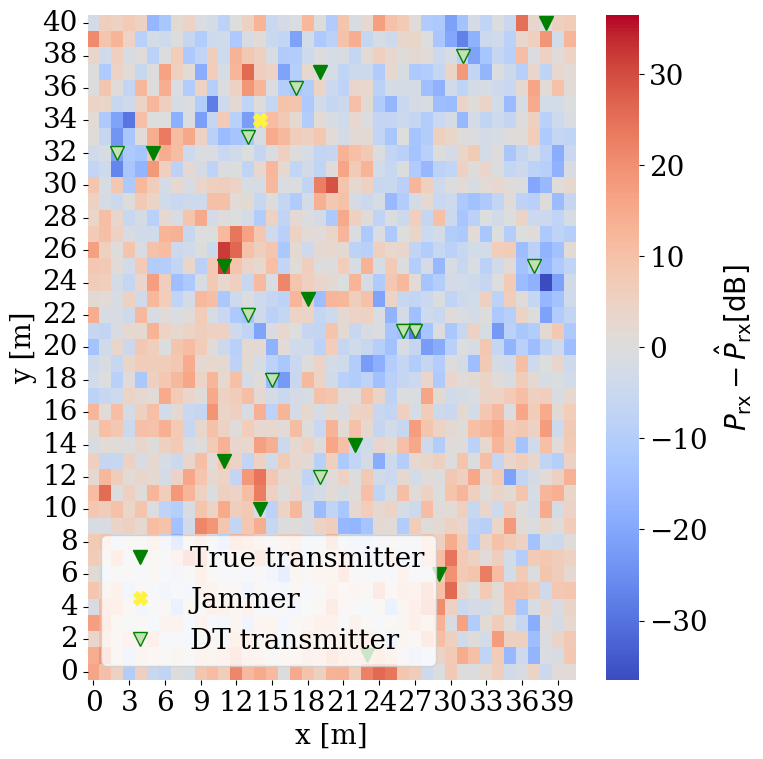

In [16]:
#implementation

import random

# Iterate through the dataset files
for file_name in os.listdir(dataset_dir):
    if file_name.startswith("fspl_RMdataset") and file_name.endswith(".pkl"):
        file_path = os.path.join(dataset_dir, file_name)

        # Load the radio map list
        print(f"Loading: {file_name}")
        radio_map_list = load_radio_map_list(file_path)

        # Randomly sample a subset of the radio maps
        sampled_radio_maps = random.sample(radio_map_list, min(5, len(radio_map_list)))
        print(f"Processing {len(sampled_radio_maps)} sampled radio maps...")

        # Analyze and visualize the sampled radio maps
        for idx, radio_map in enumerate(sampled_radio_maps):
            print(f"\n--- Radio Map {idx + 1} ---")
            analyze_radio_map(radio_map)
            visualize_radio_map(radio_map)

        # Compare the first two radio maps if available
        if len(sampled_radio_maps) > 1:
            print("\n--- Comparing the First Two Radio Maps ---")
            compare_radio_maps(sampled_radio_maps[0], sampled_radio_maps[1])




Loading the data and converting it to a dataframe format:

In [17]:
#methods
import os
import pickle
import pandas as pd

def parse_metadata_file(metadata_file):
    """
    Parse a metadata text file to extract parameters.

    Parameters:
        metadata_file (str): Path to the metadata file.

    Returns:
        dict: A dictionary containing the extracted parameters.
    """
    metadata = {}
    try:
        with open(metadata_file, 'r') as f:
            for line in f:
                line = line.strip()
                if not line or ":" not in line:  # Skip empty lines or malformed lines
                    continue
                key, value = line.split(":", 1)  # Split into key and value
                key = key.strip()
                value = value.strip()
                try:
                    # Convert numerical values to float or int
                    if "." in value:
                        value = float(value)
                    else:
                        value = int(value)
                except ValueError:
                    pass  # Keep value as string if it cannot be converted
                metadata[key] = value
    except Exception as e:
        print(f"Error parsing metadata file {metadata_file}: {e}")
    return metadata

def inspect_measurement_attributes(measurement_object):
    """
    Inspect and list the attributes of a MeasurementCollection object.

    Parameters:
        measurement_object (object): MeasurementCollection object to inspect.

    Returns:
        list: List of available attributes.
    """
    return dir(measurement_object)

def load_all_measurement_files_with_metadata(dataset_dir):
    """
    Load all .pkl measurement files and their corresponding metadata.

    Parameters:
        dataset_dir (str): Path to the dataset directory.

    Returns:
        list: A list of dictionaries containing the measurement object, its metadata, and available attributes.
    """
    measurement_data = []
    for file in os.listdir(dataset_dir):
        if file.startswith("fspl_measurements") and file.endswith(".pkl"):
            base_filename = file[:-4]  # Remove ".pkl"
            pkl_file = os.path.join(dataset_dir, file)
            txt_file = os.path.join(dataset_dir, f"{base_filename}.txt")
            
            # Load the measurement object
            try:
                with open(pkl_file, 'rb') as f:
                    measurement_object = pickle.load(f)
            except Exception as e:
                print(f"Error loading file {pkl_file}: {e}")
                continue
            
            # Load the metadata
            metadata = parse_metadata_file(txt_file) if os.path.exists(txt_file) else {}
            metadata["filename"] = file
            
            # Inspect attributes
            attributes = inspect_measurement_attributes(measurement_object)
            
            # Append measurement, metadata, and attributes
            measurement_data.append({
                "measurements": measurement_object,
                "metadata": metadata,
                "attributes": attributes
            })
    return measurement_data

def process_measurements_to_dataframe_with_metadata(measurement_data):
    """
    Convert measurement data (with metadata) into a structured format, handling variable-length attributes.

    Parameters:
        measurement_data (list): List of dictionaries containing measurements and metadata.

    Returns:
        dict: Dictionary of DataFrames, one for each iterable attribute.
    """
    consolidated_data = {}

    for entry in measurement_data:
        measurements = entry["measurements"]
        metadata = entry["metadata"]

        try:
            # Extract scalar metadata
            scalar_data = {
                "filename": metadata.get("filename", "unknown"),
                "noise_std": metadata.get("noise_std", None),
                "grid_size": getattr(measurements, "grid_size", None),
                "method": getattr(measurements, "method", None),
            }

            # Iterate over attributes in the MeasurementCollection
            for attr in ["meas_x", "meas_y", "measurements_diff_list", "jammers_list", "transmitters_list"]:
                if hasattr(measurements, attr):
                    attr_data = getattr(measurements, attr)
                    
                    # Ensure the attribute is iterable and non-empty
                    if isinstance(attr_data, (list, np.ndarray)) and len(attr_data) > 0:
                        df = pd.DataFrame({attr: attr_data})

                        # Add scalar metadata to each row of the DataFrame
                        for key, value in scalar_data.items():
                            df[key] = value
                        
                        # Append or create the DataFrame for this attribute
                        if attr in consolidated_data:
                            consolidated_data[attr] = pd.concat([consolidated_data[attr], df], ignore_index=True)
                        else:
                            consolidated_data[attr] = df

        except Exception as e:
            print(f"Error processing {metadata.get('filename', 'unknown')}: {e}")

    return consolidated_data




In [18]:
#implementation

# Load all measurement files and their metadata
measurement_data = load_all_measurement_files_with_metadata(dataset_dir)

# Inspect available attributes for each measurement object
for entry in measurement_data:
    print(f"File: {entry['metadata']['filename']}")
    print(f"Attributes: {entry['attributes']}\n")

# Process the measurements into structured DataFrames
dataframes_dict = process_measurements_to_dataframe_with_metadata(measurement_data)

# Inspect resulting DataFrames
for attr, df in dataframes_dict.items():
    print(f"DataFrame for {attr}:")
    print(df.head())  # Display the first few rows




File: fspl_measurements0.pkl
Attributes: ['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'add_measurement', 'grid_size', 'jammers_list', 'meas_x', 'meas_y', 'measurements_diff_list', 'method', 'transmitters_list']

File: fspl_measurements1.pkl
Attributes: ['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'add_measurement', 'grid_size', 'jammers_list', 'meas_x', 'meas_y', 'm